In [1]:
# Parameters
patient = 1
device = "cpu"


In [2]:
%config InlineBackend.figure_format = 'svg'

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle
from models import NonLinearController, ClosedLoopSystem
from Rens import REN_IQC_gamma, DualREN
from utils import set_params, set_QR, ensure_3d
from torch.utils.data import DataLoader, random_split, Subset
from ParametersFunctions import Parameter, PID_functions, MinMaxScalerTorch
from pathlib import Path
import scipy.io as sio
from dataset import LoadData

In [3]:
# Parameters
# ------------
# If ecxecuted with papermill these parameters are overwritten.

patient = globals().get("patient", None)
device = globals().get("device", None)

# if not passed in papermill, set preferred values for manual use
if patient is None:
    patient = 1   # <-- preferred patient for manual use
if device is None:
    device = "cpu"  # <-- preferred device for manual use

# can add like this more optional parameters like batch size, epochs, learning rate, etc.

print(f"[INFO] Training per patient: {patient}    on device: {device}")




# Define simulation parameters
torch.set_default_dtype(torch.float64)

x0, input_dim, output_dim, dim_internal, dim_nl, y_init, IQC_type, gamma, learning_rate, epochs, data_path, model_folder, redo_save, ts, use_noise, num_days = set_params()

[INFO] Training per patient: 1    on device: cpu


In [4]:
#-------------------------2. Generate closed loop data---------------------------------------------


# consecutive days split
train_size = int(num_days*0.8*1440//ts)
val_size = int(num_days*0.1*1440//ts)
test_size = int(num_days*0.1*1440//ts)

# it is normalized, has as method also the scaler to denormalize
dataset = LoadData(patient, data_path, use_noise, train_size+50)


train_dataset = torch.utils.data.Subset(dataset, range(0, train_size+50))
val_dataset   = torch.utils.data.Subset(dataset, range(train_size+50, train_size+50 + val_size))
test_dataset  = torch.utils.data.Subset(dataset, range(train_size+50 + val_size, train_size + val_size + test_size))

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


#------------------------- save scalers ---------------------------------------------------

scaler_glucose = dataset.scaler_glucose
scaler_insulin = dataset.scaler_insulin
scaler_meal    = dataset.scaler_meal

if redo_save:
    # Save the scalers
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save(scaler_glucose, MODEL_PATH / 'scaler_glucose.pth')
    torch.save(scaler_insulin, MODEL_PATH / 'scaler_insulin.pth')
    torch.save(scaler_meal,    MODEL_PATH / 'scaler_meal.pth')
    
    sio.savemat(MODEL_PATH / 'scalers.mat', {
    'glucose_low':  scaler_glucose.params['low'].item(),
    'glucose_high': scaler_glucose.params['high'].item(),
    'insulin_low':  scaler_insulin.params['low'].item(),
    'insulin_high': scaler_insulin.params['high'].item(),
    'meal_low':     scaler_meal.params['low'].item(),
    'meal_high':    scaler_meal.params['high'].item()
})


C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\models.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  basal = torch.tensor(basal, dtype=torch.float32)
C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\models.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bolus = torch.tensor(bolus, dtype=torch.float32)


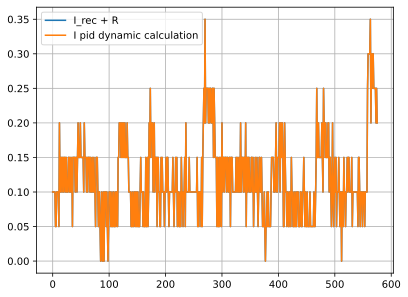

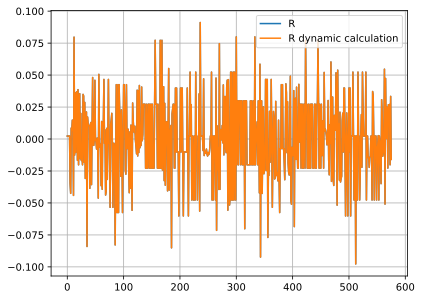

In [5]:
CGM   = (scaler_glucose.denormalize(dataset.CGM.detach())).numpy();              G     = (scaler_glucose.denormalize(dataset.G.detach())).numpy()
                                                                                                                                 
I_sat       = (scaler_insulin.denormalize(dataset.I_sat.detach())).numpy();      I_rec = (scaler_insulin.denormalize(dataset.I_rec.detach())).numpy();       
I_sat_rec   = (scaler_insulin.denormalize(dataset.I_sat_rec.detach())).numpy();  R     = (scaler_insulin.denormalize(dataset.R.detach())).numpy()

M       = (scaler_meal.denormalize(dataset.M.detach())).numpy();                 MH    = (scaler_meal.denormalize(dataset.MH.detach())).numpy();          
MH_rec  = (scaler_meal.denormalize(dataset.MH_rec.detach())).numpy()
H       = (scaler_meal.denormalize(dataset.H.detach())).numpy();                 H_rec = (scaler_meal.denormalize(dataset.H_rec.detach())).numpy();     

# R = I_sat (from .mat) - I_rec (exiting the PID and before saturation and noise)
# if  use_noise = True, R contains the noise and the saturation effect


# ------------------------- PID controller dynamic simulation ---------------------------------------------------
CGM_torch = dataset.CGM
loaded_parameters = Parameter(patient)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
u_pid, u_pid_rwgn, u_pid_rwgn_sat, r = controller(CGM_torch)


u_pid           = scaler_insulin.denormalize(u_pid.detach())
u_pid_rwgn      = scaler_insulin.denormalize(u_pid_rwgn.detach())
u_pid_rwgn_sat  = scaler_insulin.denormalize(u_pid_rwgn_sat.detach())
r               = scaler_insulin.denormalize(r.detach())

plt.figure()
plt.plot(I_rec[:2*1440//ts]+ R[:2*1440//ts], label= 'I_rec + R')
plt.plot(u_pid_rwgn_sat.numpy()[:2*1440//ts], label = 'I pid dynamic calculation');             plt.legend();plt.grid(True); plt.show()

plt.figure()
plt.plot(R[:2*1440//ts], label= 'R')
plt.plot(r.numpy()[:2*1440//ts], label = 'R dynamic calculation');                             plt.legend();plt.grid(True); plt.show()


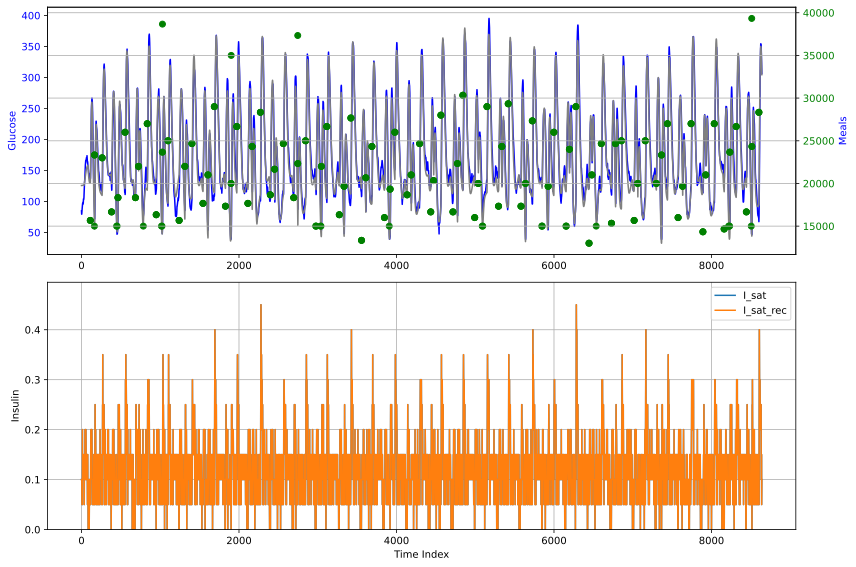

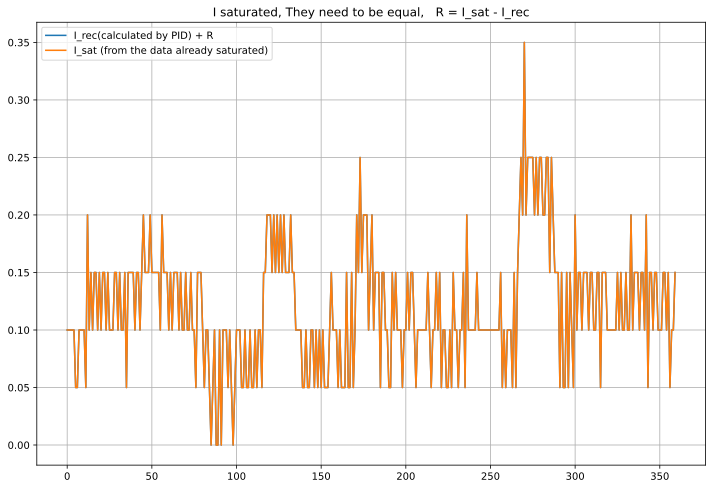

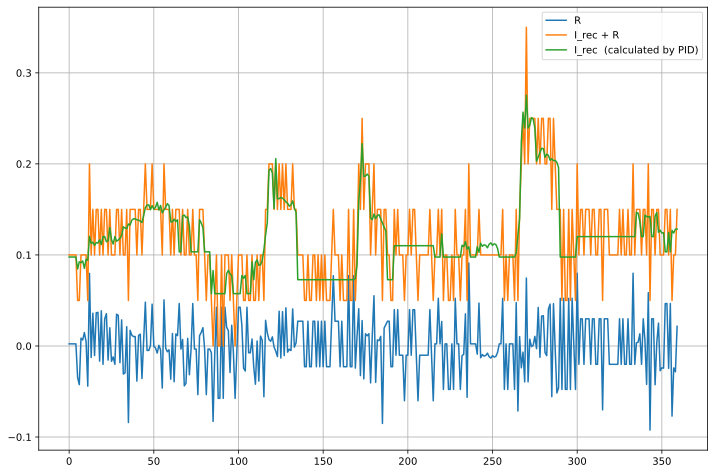

In [6]:
plt.figure(1, figsize=(12, 8))

# Subplot 1
ax1 = plt.subplot(2, 1, 1)
ax1.plot(CGM[:], 'b-', label='Glucose sensor CGM')
ax1.plot(G[:], 'gray', label='Glucose');                                                               ax1.set_ylabel('Glucose', color='b'); ax1.tick_params(axis='y', labelcolor='b'); ax1_right = ax1.twinx()
MHtemp = MH[:].copy()
ax1_right.scatter(np.arange(len(MHtemp))[MHtemp!=0], MHtemp[MHtemp!=0], color='g', label='Meals and hypo');         ax1_right.set_ylabel('Meals', color='b'); ax1_right.tick_params(axis='y', labelcolor='g'); plt.grid(True)

# Subplot 2
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(range(len(I_sat[:])), I_sat[:].flatten(), label='I_sat')
ax2.plot(range(len(I_sat_rec[:])), I_sat_rec[:], label='I_sat_rec');                                      ax2.set_ylim([0, np.max(I_sat_rec) * 1.1]); ax2.legend(); ax2.set_xlabel('Time Index'); ax2.set_ylabel('Insulin')

plt.tight_layout(); plt.grid(True); plt.show()



plt.figure(3, figsize=(12, 8))
plt.plot(I_rec[:1440//4]+ R[:1440//4], label = 'I_rec(calculated by PID) + R')
plt.plot(I_sat[:1440//4], label= 'I_sat (from the data already saturated)')
plt.title('I saturated, They need to be equal,   R = I_sat - I_rec');                   plt.legend();plt.grid(True); plt.show()

plt.figure(4, figsize=(12, 8))
plt.plot(R[:1440//4], label= 'R')
plt.plot(I_rec[:1440//4]+ R[:1440//4], label= 'I_rec + R')
plt.plot(I_rec[:1440//4], label = 'I_rec  (calculated by PID)');                             plt.legend();plt.grid(True); plt.show()


# plt.figure(5)
# plt.plot(H, label='H')
# plt.plot(H_rec-100, label='H_rec')
# plt.title('Hypoglycemia Treatments Comparison');                                                    plt.legend(); plt.show()
#
# plt.figure(6)
# plt.plot(CGM[:1440//4], 'b-', label='Glucose sensor CGM')
# plt.plot(G[:1440//4], 'gray', label='Glucose')
# plt.figure(1, figsize=(12, 8))


In [7]:
#--------------------------3. Define model for sysid---------------------------------------------


device = torch.device(device if torch.cuda.is_available() else "cpu")

# meal   M 
REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

# insulin  I_sat
REN_1 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)

REN_0 = REN_0.to(device)
REN_1 = REN_1.to(device)

#create the closed loop with the identified model
# closed_loop_G = ClosedLoopSystem(REN_G, controller)

#--------------------------4. Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()

optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_1.parameters()),   lr=learning_rate)
optimizer.zero_grad()

C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\Rens.py:313: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4419.)
  self.x = torch.linalg.lstsq(self.C2, y_init.squeeze(1).T)[0].T.unsqueeze(0).unsqueeze(0)


In [8]:
#--------------------------5. Training---------------------------------------------------------------------

torch.set_default_device(device)      # default tensor device
torch.set_default_dtype(torch.float32)  # default tensor dtype
print(f"[INFO] Training on device: {device}")

REN_0.to(device); REN_1.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs
for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_1.train()
    loss_epoch = 0.0  # Accumulate training loss

    
    for u0_batch, _, _, u1_batch, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        
        u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        REN_0.reset(); REN_1.reset()

        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_1(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()
        optimizer.step()
        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_1.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time

            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_1.reset()

            y0_hat_val = REN_0(u0_batch)
            y1_hat_val = REN_1(u1_batch)# select the correct U
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_1 = REN_1

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_1_cpu = candidate_REN_1.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_1" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_1_state_dict': candidate_REN_1_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})


[INFO] Training on device: cpu


Epoch: 1 	||	 Training Loss: 0.255659 	||	 Validation Loss: 0.255441


Epoch: 2 	||	 Training Loss: 0.252936 	||	 Validation Loss: 0.252749


Epoch: 3 	||	 Training Loss: 0.250262 	||	 Validation Loss: 0.250104


Epoch: 4 	||	 Training Loss: 0.247636 	||	 Validation Loss: 0.247506


Epoch: 5 	||	 Training Loss: 0.245056 	||	 Validation Loss: 0.244950


Epoch: 6 	||	 Training Loss: 0.242518 	||	 Validation Loss: 0.242433


Epoch: 7 	||	 Training Loss: 0.240019 	||	 Validation Loss: 0.239951


Epoch: 8 	||	 Training Loss: 0.237555 	||	 Validation Loss: 0.237500


Epoch: 9 	||	 Training Loss: 0.235122 	||	 Validation Loss: 0.235077


Epoch: 10 	||	 Training Loss: 0.232717 	||	 Validation Loss: 0.232677


Epoch: 11 	||	 Training Loss: 0.230335 	||	 Validation Loss: 0.230297


Epoch: 12 	||	 Training Loss: 0.227972 	||	 Validation Loss: 0.227933


Epoch: 13 	||	 Training Loss: 0.225625 	||	 Validation Loss: 0.225579


Epoch: 14 	||	 Training Loss: 0.223289 	||	 Validation Loss: 0.223231


Epoch: 15 	||	 Training Loss: 0.220959 	||	 Validation Loss: 0.220885


Epoch: 16 	||	 Training Loss: 0.218631 	||	 Validation Loss: 0.218537


Epoch: 17 	||	 Training Loss: 0.216300 	||	 Validation Loss: 0.216180


Epoch: 18 	||	 Training Loss: 0.213961 	||	 Validation Loss: 0.213810


Epoch: 19 	||	 Training Loss: 0.211610 	||	 Validation Loss: 0.211423


Epoch: 20 	||	 Training Loss: 0.209240 	||	 Validation Loss: 0.209012


Epoch: 21 	||	 Training Loss: 0.206848 	||	 Validation Loss: 0.206573


Epoch: 22 	||	 Training Loss: 0.204427 	||	 Validation Loss: 0.204100


Epoch: 23 	||	 Training Loss: 0.201973 	||	 Validation Loss: 0.201588


Epoch: 24 	||	 Training Loss: 0.199480 	||	 Validation Loss: 0.199031


Epoch: 25 	||	 Training Loss: 0.196943 	||	 Validation Loss: 0.196424


Epoch: 26 	||	 Training Loss: 0.194356 	||	 Validation Loss: 0.193762


Epoch: 27 	||	 Training Loss: 0.191713 	||	 Validation Loss: 0.191038


Epoch: 28 	||	 Training Loss: 0.189010 	||	 Validation Loss: 0.188247


Epoch: 29 	||	 Training Loss: 0.186240 	||	 Validation Loss: 0.185383


Epoch: 30 	||	 Training Loss: 0.183397 	||	 Validation Loss: 0.182440


Epoch: 31 	||	 Training Loss: 0.180475 	||	 Validation Loss: 0.179411


Epoch: 32 	||	 Training Loss: 0.177469 	||	 Validation Loss: 0.176292


Epoch: 33 	||	 Training Loss: 0.174372 	||	 Validation Loss: 0.173077


Epoch: 34 	||	 Training Loss: 0.171179 	||	 Validation Loss: 0.169758


Epoch: 35 	||	 Training Loss: 0.167884 	||	 Validation Loss: 0.166332


Epoch: 36 	||	 Training Loss: 0.164482 	||	 Validation Loss: 0.162792


Epoch: 37 	||	 Training Loss: 0.160966 	||	 Validation Loss: 0.159133


Epoch: 38 	||	 Training Loss: 0.157332 	||	 Validation Loss: 0.155350


Epoch: 39 	||	 Training Loss: 0.153574 	||	 Validation Loss: 0.151437


Epoch: 40 	||	 Training Loss: 0.149688 	||	 Validation Loss: 0.147392


Epoch: 41 	||	 Training Loss: 0.145669 	||	 Validation Loss: 0.143210


Epoch: 42 	||	 Training Loss: 0.141514 	||	 Validation Loss: 0.138888


Epoch: 43 	||	 Training Loss: 0.137221 	||	 Validation Loss: 0.134425


Epoch: 44 	||	 Training Loss: 0.132786 	||	 Validation Loss: 0.129820


Epoch: 45 	||	 Training Loss: 0.128210 	||	 Validation Loss: 0.125073


Epoch: 46 	||	 Training Loss: 0.123493 	||	 Validation Loss: 0.120187


Epoch: 47 	||	 Training Loss: 0.118638 	||	 Validation Loss: 0.115167


Epoch: 48 	||	 Training Loss: 0.113649 	||	 Validation Loss: 0.110019


Epoch: 49 	||	 Training Loss: 0.108533 	||	 Validation Loss: 0.104753


Epoch: 50 	||	 Training Loss: 0.103300 	||	 Validation Loss: 0.099381


Epoch: 51 	||	 Training Loss: 0.097961 	||	 Validation Loss: 0.093920


Epoch: 52 	||	 Training Loss: 0.092535 	||	 Validation Loss: 0.088391


Epoch: 53 	||	 Training Loss: 0.087041 	||	 Validation Loss: 0.082820


Epoch: 54 	||	 Training Loss: 0.081505 	||	 Validation Loss: 0.077236


Epoch: 55 	||	 Training Loss: 0.075958 	||	 Validation Loss: 0.071678


Epoch: 56 	||	 Training Loss: 0.070437 	||	 Validation Loss: 0.066188


Epoch: 57 	||	 Training Loss: 0.064986 	||	 Validation Loss: 0.060818


Epoch: 58 	||	 Training Loss: 0.059656 	||	 Validation Loss: 0.055625


Epoch: 59 	||	 Training Loss: 0.054504 	||	 Validation Loss: 0.050676


Epoch: 60 	||	 Training Loss: 0.049598 	||	 Validation Loss: 0.046042


Epoch: 61 	||	 Training Loss: 0.045008 	||	 Validation Loss: 0.041802


Epoch: 62 	||	 Training Loss: 0.040815 	||	 Validation Loss: 0.038036


Epoch: 63 	||	 Training Loss: 0.037097 	||	 Validation Loss: 0.034822


Epoch: 64 	||	 Training Loss: 0.033935 	||	 Validation Loss: 0.032233


Epoch: 65 	||	 Training Loss: 0.031399 	||	 Validation Loss: 0.030321


Epoch: 66 	||	 Training Loss: 0.029544 	||	 Validation Loss: 0.029112


Epoch: 67 	||	 Training Loss: 0.028394 	||	 Validation Loss: 0.028590


Epoch: 68 	||	 Training Loss: 0.027932 	||	 Validation Loss: 0.028685


Epoch: 69 	||	 Training Loss: 0.028086 	||	 Validation Loss: 0.029269


Epoch: 70 	||	 Training Loss: 0.028727 	||	 Validation Loss: 0.030162


Epoch: 71 	||	 Training Loss: 0.029672 	||	 Validation Loss: 0.031154


Epoch: 72 	||	 Training Loss: 0.030708 	||	 Validation Loss: 0.032043


Epoch: 73 	||	 Training Loss: 0.031629 	||	 Validation Loss: 0.032667


Epoch: 74 	||	 Training Loss: 0.032274 	||	 Validation Loss: 0.032939


Epoch: 75 	||	 Training Loss: 0.032552 	||	 Validation Loss: 0.032844


Epoch: 76 	||	 Training Loss: 0.032450 	||	 Validation Loss: 0.032433


Epoch: 77 	||	 Training Loss: 0.032021 	||	 Validation Loss: 0.031794


Epoch: 78 	||	 Training Loss: 0.031355 	||	 Validation Loss: 0.031033


Epoch: 79 	||	 Training Loss: 0.030561 	||	 Validation Loss: 0.030249


Epoch: 80 	||	 Training Loss: 0.029739 	||	 Validation Loss: 0.029520


Epoch: 81 	||	 Training Loss: 0.028971 	||	 Validation Loss: 0.028903


Epoch: 82 	||	 Training Loss: 0.028314 	||	 Validation Loss: 0.028426


Epoch: 83 	||	 Training Loss: 0.027799 	||	 Validation Loss: 0.028095


Epoch: 84 	||	 Training Loss: 0.027432 	||	 Validation Loss: 0.027901


Epoch: 85 	||	 Training Loss: 0.027203 	||	 Validation Loss: 0.027820


Epoch: 86 	||	 Training Loss: 0.027092 	||	 Validation Loss: 0.027826


Epoch: 87 	||	 Training Loss: 0.027072 	||	 Validation Loss: 0.027891


Epoch: 88 	||	 Training Loss: 0.027112 	||	 Validation Loss: 0.027985


Epoch: 89 	||	 Training Loss: 0.027186 	||	 Validation Loss: 0.028086


Epoch: 90 	||	 Training Loss: 0.027271 	||	 Validation Loss: 0.028176


Epoch: 91 	||	 Training Loss: 0.027347 	||	 Validation Loss: 0.028241


Epoch: 92 	||	 Training Loss: 0.027401 	||	 Validation Loss: 0.028272


Epoch: 93 	||	 Training Loss: 0.027424 	||	 Validation Loss: 0.028267


Epoch: 94 	||	 Training Loss: 0.027413 	||	 Validation Loss: 0.028224


Epoch: 95 	||	 Training Loss: 0.027368 	||	 Validation Loss: 0.028149


Epoch: 96 	||	 Training Loss: 0.027291 	||	 Validation Loss: 0.028045


Epoch: 97 	||	 Training Loss: 0.027189 	||	 Validation Loss: 0.027922


Epoch: 98 	||	 Training Loss: 0.027069 	||	 Validation Loss: 0.027786


Epoch: 99 	||	 Training Loss: 0.026937 	||	 Validation Loss: 0.027646


Epoch: 100 	||	 Training Loss: 0.026803 	||	 Validation Loss: 0.027509


Epoch: 101 	||	 Training Loss: 0.026672 	||	 Validation Loss: 0.027381


Epoch: 102 	||	 Training Loss: 0.026552 	||	 Validation Loss: 0.027267


Epoch: 103 	||	 Training Loss: 0.026446 	||	 Validation Loss: 0.027169


Epoch: 104 	||	 Training Loss: 0.026356 	||	 Validation Loss: 0.027089


Epoch: 105 	||	 Training Loss: 0.026284 	||	 Validation Loss: 0.027026


Epoch: 106 	||	 Training Loss: 0.026229 	||	 Validation Loss: 0.026977


Epoch: 107 	||	 Training Loss: 0.026187 	||	 Validation Loss: 0.026940


Epoch: 108 	||	 Training Loss: 0.026156 	||	 Validation Loss: 0.026910


Epoch: 109 	||	 Training Loss: 0.026131 	||	 Validation Loss: 0.026884


Epoch: 110 	||	 Training Loss: 0.026109 	||	 Validation Loss: 0.026858


Epoch: 111 	||	 Training Loss: 0.026086 	||	 Validation Loss: 0.026829


Epoch: 112 	||	 Training Loss: 0.026058 	||	 Validation Loss: 0.026796


Epoch: 113 	||	 Training Loss: 0.026025 	||	 Validation Loss: 0.026758


Epoch: 114 	||	 Training Loss: 0.025985 	||	 Validation Loss: 0.026715


Epoch: 115 	||	 Training Loss: 0.025939 	||	 Validation Loss: 0.026668


Epoch: 116 	||	 Training Loss: 0.025887 	||	 Validation Loss: 0.026619


Epoch: 117 	||	 Training Loss: 0.025832 	||	 Validation Loss: 0.026568


Epoch: 118 	||	 Training Loss: 0.025776 	||	 Validation Loss: 0.026519


Epoch: 119 	||	 Training Loss: 0.025720 	||	 Validation Loss: 0.026471


Epoch: 120 	||	 Training Loss: 0.025665 	||	 Validation Loss: 0.026427


Epoch: 121 	||	 Training Loss: 0.025613 	||	 Validation Loss: 0.026385


Epoch: 122 	||	 Training Loss: 0.025565 	||	 Validation Loss: 0.026347


Epoch: 123 	||	 Training Loss: 0.025519 	||	 Validation Loss: 0.026312


Epoch: 124 	||	 Training Loss: 0.025477 	||	 Validation Loss: 0.026278


Epoch: 125 	||	 Training Loss: 0.025438 	||	 Validation Loss: 0.026246


Epoch: 126 	||	 Training Loss: 0.025400 	||	 Validation Loss: 0.026215


Epoch: 127 	||	 Training Loss: 0.025363 	||	 Validation Loss: 0.026183


Epoch: 128 	||	 Training Loss: 0.025327 	||	 Validation Loss: 0.026149


Epoch: 129 	||	 Training Loss: 0.025289 	||	 Validation Loss: 0.026114


Epoch: 130 	||	 Training Loss: 0.025251 	||	 Validation Loss: 0.026078


Epoch: 131 	||	 Training Loss: 0.025212 	||	 Validation Loss: 0.026039


Epoch: 132 	||	 Training Loss: 0.025172 	||	 Validation Loss: 0.026000


Epoch: 133 	||	 Training Loss: 0.025131 	||	 Validation Loss: 0.025959


Epoch: 134 	||	 Training Loss: 0.025089 	||	 Validation Loss: 0.025917


Epoch: 135 	||	 Training Loss: 0.025047 	||	 Validation Loss: 0.025875


Epoch: 136 	||	 Training Loss: 0.025005 	||	 Validation Loss: 0.025832


Epoch: 137 	||	 Training Loss: 0.024963 	||	 Validation Loss: 0.025791


Epoch: 138 	||	 Training Loss: 0.024921 	||	 Validation Loss: 0.025750


Epoch: 139 	||	 Training Loss: 0.024880 	||	 Validation Loss: 0.025709


Epoch: 140 	||	 Training Loss: 0.024840 	||	 Validation Loss: 0.025670


Epoch: 141 	||	 Training Loss: 0.024801 	||	 Validation Loss: 0.025631


Epoch: 142 	||	 Training Loss: 0.024762 	||	 Validation Loss: 0.025592


Epoch: 143 	||	 Training Loss: 0.024723 	||	 Validation Loss: 0.025555


Epoch: 144 	||	 Training Loss: 0.024685 	||	 Validation Loss: 0.025517


Epoch: 145 	||	 Training Loss: 0.024647 	||	 Validation Loss: 0.025480


Epoch: 146 	||	 Training Loss: 0.024609 	||	 Validation Loss: 0.025443


Epoch: 147 	||	 Training Loss: 0.024570 	||	 Validation Loss: 0.025406


Epoch: 148 	||	 Training Loss: 0.024532 	||	 Validation Loss: 0.025370


Epoch: 149 	||	 Training Loss: 0.024493 	||	 Validation Loss: 0.025333


Epoch: 150 	||	 Training Loss: 0.024454 	||	 Validation Loss: 0.025297


Epoch: 151 	||	 Training Loss: 0.024415 	||	 Validation Loss: 0.025261


Epoch: 152 	||	 Training Loss: 0.024376 	||	 Validation Loss: 0.025225


Epoch: 153 	||	 Training Loss: 0.024338 	||	 Validation Loss: 0.025189


Epoch: 154 	||	 Training Loss: 0.024299 	||	 Validation Loss: 0.025154


Epoch: 155 	||	 Training Loss: 0.024261 	||	 Validation Loss: 0.025118


Epoch: 156 	||	 Training Loss: 0.024223 	||	 Validation Loss: 0.025083


Epoch: 157 	||	 Training Loss: 0.024185 	||	 Validation Loss: 0.025048


Epoch: 158 	||	 Training Loss: 0.024147 	||	 Validation Loss: 0.025013


Epoch: 159 	||	 Training Loss: 0.024110 	||	 Validation Loss: 0.024978


Epoch: 160 	||	 Training Loss: 0.024072 	||	 Validation Loss: 0.024943


Epoch: 161 	||	 Training Loss: 0.024035 	||	 Validation Loss: 0.024907


Epoch: 162 	||	 Training Loss: 0.023997 	||	 Validation Loss: 0.024872


Epoch: 163 	||	 Training Loss: 0.023960 	||	 Validation Loss: 0.024836


Epoch: 164 	||	 Training Loss: 0.023922 	||	 Validation Loss: 0.024800


Epoch: 165 	||	 Training Loss: 0.023885 	||	 Validation Loss: 0.024764


Epoch: 166 	||	 Training Loss: 0.023848 	||	 Validation Loss: 0.024728


Epoch: 167 	||	 Training Loss: 0.023810 	||	 Validation Loss: 0.024691


Epoch: 168 	||	 Training Loss: 0.023773 	||	 Validation Loss: 0.024655


Epoch: 169 	||	 Training Loss: 0.023736 	||	 Validation Loss: 0.024619


Epoch: 170 	||	 Training Loss: 0.023699 	||	 Validation Loss: 0.024583


Epoch: 171 	||	 Training Loss: 0.023662 	||	 Validation Loss: 0.024548


Epoch: 172 	||	 Training Loss: 0.023625 	||	 Validation Loss: 0.024512


Epoch: 173 	||	 Training Loss: 0.023588 	||	 Validation Loss: 0.024476


Epoch: 174 	||	 Training Loss: 0.023552 	||	 Validation Loss: 0.024441


Epoch: 175 	||	 Training Loss: 0.023515 	||	 Validation Loss: 0.024406


Epoch: 176 	||	 Training Loss: 0.023478 	||	 Validation Loss: 0.024371


Epoch: 177 	||	 Training Loss: 0.023442 	||	 Validation Loss: 0.024336


Epoch: 178 	||	 Training Loss: 0.023405 	||	 Validation Loss: 0.024301


Epoch: 179 	||	 Training Loss: 0.023369 	||	 Validation Loss: 0.024266


Epoch: 180 	||	 Training Loss: 0.023333 	||	 Validation Loss: 0.024231


Epoch: 181 	||	 Training Loss: 0.023296 	||	 Validation Loss: 0.024197


Epoch: 182 	||	 Training Loss: 0.023260 	||	 Validation Loss: 0.024162


Epoch: 183 	||	 Training Loss: 0.023224 	||	 Validation Loss: 0.024128


Epoch: 184 	||	 Training Loss: 0.023188 	||	 Validation Loss: 0.024094


Epoch: 185 	||	 Training Loss: 0.023152 	||	 Validation Loss: 0.024059


Epoch: 186 	||	 Training Loss: 0.023116 	||	 Validation Loss: 0.024025


Epoch: 187 	||	 Training Loss: 0.023080 	||	 Validation Loss: 0.023991


Epoch: 188 	||	 Training Loss: 0.023044 	||	 Validation Loss: 0.023956


Epoch: 189 	||	 Training Loss: 0.023008 	||	 Validation Loss: 0.023922


Epoch: 190 	||	 Training Loss: 0.022972 	||	 Validation Loss: 0.023888


Epoch: 191 	||	 Training Loss: 0.022937 	||	 Validation Loss: 0.023854


Epoch: 192 	||	 Training Loss: 0.022901 	||	 Validation Loss: 0.023819


Epoch: 193 	||	 Training Loss: 0.022865 	||	 Validation Loss: 0.023785


Epoch: 194 	||	 Training Loss: 0.022830 	||	 Validation Loss: 0.023751


Epoch: 195 	||	 Training Loss: 0.022794 	||	 Validation Loss: 0.023716


Epoch: 196 	||	 Training Loss: 0.022759 	||	 Validation Loss: 0.023682


Epoch: 197 	||	 Training Loss: 0.022723 	||	 Validation Loss: 0.023648


Epoch: 198 	||	 Training Loss: 0.022688 	||	 Validation Loss: 0.023614


Epoch: 199 	||	 Training Loss: 0.022653 	||	 Validation Loss: 0.023580


Epoch: 200 	||	 Training Loss: 0.022618 	||	 Validation Loss: 0.023546


Epoch: 201 	||	 Training Loss: 0.022583 	||	 Validation Loss: 0.023512


Epoch: 202 	||	 Training Loss: 0.022547 	||	 Validation Loss: 0.023478


Epoch: 203 	||	 Training Loss: 0.022512 	||	 Validation Loss: 0.023444


Epoch: 204 	||	 Training Loss: 0.022477 	||	 Validation Loss: 0.023411


Epoch: 205 	||	 Training Loss: 0.022443 	||	 Validation Loss: 0.023377


Epoch: 206 	||	 Training Loss: 0.022408 	||	 Validation Loss: 0.023343


Epoch: 207 	||	 Training Loss: 0.022373 	||	 Validation Loss: 0.023310


Epoch: 208 	||	 Training Loss: 0.022338 	||	 Validation Loss: 0.023276


Epoch: 209 	||	 Training Loss: 0.022303 	||	 Validation Loss: 0.023243


Epoch: 210 	||	 Training Loss: 0.022269 	||	 Validation Loss: 0.023210


Epoch: 211 	||	 Training Loss: 0.022234 	||	 Validation Loss: 0.023177


Epoch: 212 	||	 Training Loss: 0.022200 	||	 Validation Loss: 0.023143


Epoch: 213 	||	 Training Loss: 0.022165 	||	 Validation Loss: 0.023110


Epoch: 214 	||	 Training Loss: 0.022131 	||	 Validation Loss: 0.023077


Epoch: 215 	||	 Training Loss: 0.022097 	||	 Validation Loss: 0.023044


Epoch: 216 	||	 Training Loss: 0.022062 	||	 Validation Loss: 0.023011


Epoch: 217 	||	 Training Loss: 0.022028 	||	 Validation Loss: 0.022978


Epoch: 218 	||	 Training Loss: 0.021994 	||	 Validation Loss: 0.022945


Epoch: 219 	||	 Training Loss: 0.021960 	||	 Validation Loss: 0.022912


Epoch: 220 	||	 Training Loss: 0.021926 	||	 Validation Loss: 0.022879


Epoch: 221 	||	 Training Loss: 0.021892 	||	 Validation Loss: 0.022846


Epoch: 222 	||	 Training Loss: 0.021858 	||	 Validation Loss: 0.022813


Epoch: 223 	||	 Training Loss: 0.021824 	||	 Validation Loss: 0.022781


Epoch: 224 	||	 Training Loss: 0.021791 	||	 Validation Loss: 0.022748


Epoch: 225 	||	 Training Loss: 0.021757 	||	 Validation Loss: 0.022715


Epoch: 226 	||	 Training Loss: 0.021723 	||	 Validation Loss: 0.022683


Epoch: 227 	||	 Training Loss: 0.021690 	||	 Validation Loss: 0.022650


Epoch: 228 	||	 Training Loss: 0.021656 	||	 Validation Loss: 0.022618


Epoch: 229 	||	 Training Loss: 0.021623 	||	 Validation Loss: 0.022586


Epoch: 230 	||	 Training Loss: 0.021590 	||	 Validation Loss: 0.022553


Epoch: 231 	||	 Training Loss: 0.021556 	||	 Validation Loss: 0.022521


Epoch: 232 	||	 Training Loss: 0.021523 	||	 Validation Loss: 0.022489


Epoch: 233 	||	 Training Loss: 0.021490 	||	 Validation Loss: 0.022457


Epoch: 234 	||	 Training Loss: 0.021457 	||	 Validation Loss: 0.022425


Epoch: 235 	||	 Training Loss: 0.021424 	||	 Validation Loss: 0.022394


Epoch: 236 	||	 Training Loss: 0.021391 	||	 Validation Loss: 0.022362


Epoch: 237 	||	 Training Loss: 0.021359 	||	 Validation Loss: 0.022330


Epoch: 238 	||	 Training Loss: 0.021326 	||	 Validation Loss: 0.022299


Epoch: 239 	||	 Training Loss: 0.021293 	||	 Validation Loss: 0.022267


Epoch: 240 	||	 Training Loss: 0.021261 	||	 Validation Loss: 0.022236


Epoch: 241 	||	 Training Loss: 0.021229 	||	 Validation Loss: 0.022204


Epoch: 242 	||	 Training Loss: 0.021196 	||	 Validation Loss: 0.022173


Epoch: 243 	||	 Training Loss: 0.021164 	||	 Validation Loss: 0.022142


Epoch: 244 	||	 Training Loss: 0.021132 	||	 Validation Loss: 0.022111


Epoch: 245 	||	 Training Loss: 0.021100 	||	 Validation Loss: 0.022080


Epoch: 246 	||	 Training Loss: 0.021068 	||	 Validation Loss: 0.022049


Epoch: 247 	||	 Training Loss: 0.021036 	||	 Validation Loss: 0.022018


Epoch: 248 	||	 Training Loss: 0.021004 	||	 Validation Loss: 0.021987


Epoch: 249 	||	 Training Loss: 0.020973 	||	 Validation Loss: 0.021957


Epoch: 250 	||	 Training Loss: 0.020941 	||	 Validation Loss: 0.021926


Epoch: 251 	||	 Training Loss: 0.020910 	||	 Validation Loss: 0.021896


Epoch: 252 	||	 Training Loss: 0.020878 	||	 Validation Loss: 0.021866


Epoch: 253 	||	 Training Loss: 0.020847 	||	 Validation Loss: 0.021836


Epoch: 254 	||	 Training Loss: 0.020816 	||	 Validation Loss: 0.021806


Epoch: 255 	||	 Training Loss: 0.020785 	||	 Validation Loss: 0.021776


Epoch: 256 	||	 Training Loss: 0.020754 	||	 Validation Loss: 0.021746


Epoch: 257 	||	 Training Loss: 0.020723 	||	 Validation Loss: 0.021716


Epoch: 258 	||	 Training Loss: 0.020693 	||	 Validation Loss: 0.021687


Epoch: 259 	||	 Training Loss: 0.020662 	||	 Validation Loss: 0.021657


Epoch: 260 	||	 Training Loss: 0.020632 	||	 Validation Loss: 0.021628


Epoch: 261 	||	 Training Loss: 0.020602 	||	 Validation Loss: 0.021599


Epoch: 262 	||	 Training Loss: 0.020572 	||	 Validation Loss: 0.021570


Epoch: 263 	||	 Training Loss: 0.020542 	||	 Validation Loss: 0.021541


Epoch: 264 	||	 Training Loss: 0.020512 	||	 Validation Loss: 0.021512


Epoch: 265 	||	 Training Loss: 0.020482 	||	 Validation Loss: 0.021483


Epoch: 266 	||	 Training Loss: 0.020452 	||	 Validation Loss: 0.021455


Epoch: 267 	||	 Training Loss: 0.020423 	||	 Validation Loss: 0.021426


Epoch: 268 	||	 Training Loss: 0.020394 	||	 Validation Loss: 0.021398


Epoch: 269 	||	 Training Loss: 0.020364 	||	 Validation Loss: 0.021370


Epoch: 270 	||	 Training Loss: 0.020335 	||	 Validation Loss: 0.021342


Epoch: 271 	||	 Training Loss: 0.020306 	||	 Validation Loss: 0.021314


Epoch: 272 	||	 Training Loss: 0.020278 	||	 Validation Loss: 0.021286


Epoch: 273 	||	 Training Loss: 0.020249 	||	 Validation Loss: 0.021259


Epoch: 274 	||	 Training Loss: 0.020221 	||	 Validation Loss: 0.021232


Epoch: 275 	||	 Training Loss: 0.020192 	||	 Validation Loss: 0.021204


Epoch: 276 	||	 Training Loss: 0.020164 	||	 Validation Loss: 0.021177


Epoch: 277 	||	 Training Loss: 0.020136 	||	 Validation Loss: 0.021150


Epoch: 278 	||	 Training Loss: 0.020109 	||	 Validation Loss: 0.021124


Epoch: 279 	||	 Training Loss: 0.020081 	||	 Validation Loss: 0.021097


Epoch: 280 	||	 Training Loss: 0.020053 	||	 Validation Loss: 0.021071


Epoch: 281 	||	 Training Loss: 0.020026 	||	 Validation Loss: 0.021044


Epoch: 282 	||	 Training Loss: 0.019999 	||	 Validation Loss: 0.021018


Epoch: 283 	||	 Training Loss: 0.019972 	||	 Validation Loss: 0.020992


Epoch: 284 	||	 Training Loss: 0.019945 	||	 Validation Loss: 0.020967


Epoch: 285 	||	 Training Loss: 0.019919 	||	 Validation Loss: 0.020941


Epoch: 286 	||	 Training Loss: 0.019892 	||	 Validation Loss: 0.020916


Epoch: 287 	||	 Training Loss: 0.019866 	||	 Validation Loss: 0.020890


Epoch: 288 	||	 Training Loss: 0.019840 	||	 Validation Loss: 0.020865


Epoch: 289 	||	 Training Loss: 0.019814 	||	 Validation Loss: 0.020840


Epoch: 290 	||	 Training Loss: 0.019789 	||	 Validation Loss: 0.020816


Epoch: 291 	||	 Training Loss: 0.019763 	||	 Validation Loss: 0.020791


Epoch: 292 	||	 Training Loss: 0.019738 	||	 Validation Loss: 0.020767


Epoch: 293 	||	 Training Loss: 0.019713 	||	 Validation Loss: 0.020743


Epoch: 294 	||	 Training Loss: 0.019688 	||	 Validation Loss: 0.020719


Epoch: 295 	||	 Training Loss: 0.019663 	||	 Validation Loss: 0.020695


Epoch: 296 	||	 Training Loss: 0.019639 	||	 Validation Loss: 0.020671


Epoch: 297 	||	 Training Loss: 0.019615 	||	 Validation Loss: 0.020648


Epoch: 298 	||	 Training Loss: 0.019590 	||	 Validation Loss: 0.020624


Epoch: 299 	||	 Training Loss: 0.019567 	||	 Validation Loss: 0.020601


Epoch: 300 	||	 Training Loss: 0.019543 	||	 Validation Loss: 0.020578


Epoch: 301 	||	 Training Loss: 0.019519 	||	 Validation Loss: 0.020555


Epoch: 302 	||	 Training Loss: 0.019496 	||	 Validation Loss: 0.020533


Epoch: 303 	||	 Training Loss: 0.019473 	||	 Validation Loss: 0.020510


Epoch: 304 	||	 Training Loss: 0.019450 	||	 Validation Loss: 0.020488


Epoch: 305 	||	 Training Loss: 0.019427 	||	 Validation Loss: 0.020466


Epoch: 306 	||	 Training Loss: 0.019405 	||	 Validation Loss: 0.020444


Epoch: 307 	||	 Training Loss: 0.019382 	||	 Validation Loss: 0.020422


Epoch: 308 	||	 Training Loss: 0.019360 	||	 Validation Loss: 0.020400


Epoch: 309 	||	 Training Loss: 0.019338 	||	 Validation Loss: 0.020379


Epoch: 310 	||	 Training Loss: 0.019317 	||	 Validation Loss: 0.020358


Epoch: 311 	||	 Training Loss: 0.019295 	||	 Validation Loss: 0.020336


Epoch: 312 	||	 Training Loss: 0.019274 	||	 Validation Loss: 0.020315


Epoch: 313 	||	 Training Loss: 0.019252 	||	 Validation Loss: 0.020294


Epoch: 314 	||	 Training Loss: 0.019231 	||	 Validation Loss: 0.020274


Epoch: 315 	||	 Training Loss: 0.019211 	||	 Validation Loss: 0.020253


Epoch: 316 	||	 Training Loss: 0.019190 	||	 Validation Loss: 0.020233


Epoch: 317 	||	 Training Loss: 0.019169 	||	 Validation Loss: 0.020212


Epoch: 318 	||	 Training Loss: 0.019149 	||	 Validation Loss: 0.020192


Epoch: 319 	||	 Training Loss: 0.019129 	||	 Validation Loss: 0.020172


Epoch: 320 	||	 Training Loss: 0.019109 	||	 Validation Loss: 0.020152


Epoch: 321 	||	 Training Loss: 0.019089 	||	 Validation Loss: 0.020132


Epoch: 322 	||	 Training Loss: 0.019070 	||	 Validation Loss: 0.020113


Epoch: 323 	||	 Training Loss: 0.019050 	||	 Validation Loss: 0.020093


Epoch: 324 	||	 Training Loss: 0.019031 	||	 Validation Loss: 0.020074


Epoch: 325 	||	 Training Loss: 0.019012 	||	 Validation Loss: 0.020054


Epoch: 326 	||	 Training Loss: 0.018993 	||	 Validation Loss: 0.020035


Epoch: 327 	||	 Training Loss: 0.018974 	||	 Validation Loss: 0.020016


Epoch: 328 	||	 Training Loss: 0.018955 	||	 Validation Loss: 0.019997


Epoch: 329 	||	 Training Loss: 0.018937 	||	 Validation Loss: 0.019978


Epoch: 330 	||	 Training Loss: 0.018918 	||	 Validation Loss: 0.019960


Epoch: 331 	||	 Training Loss: 0.018900 	||	 Validation Loss: 0.019941


Epoch: 332 	||	 Training Loss: 0.018882 	||	 Validation Loss: 0.019922


Epoch: 333 	||	 Training Loss: 0.018864 	||	 Validation Loss: 0.019904


Epoch: 334 	||	 Training Loss: 0.018846 	||	 Validation Loss: 0.019886


Epoch: 335 	||	 Training Loss: 0.018829 	||	 Validation Loss: 0.019868


Epoch: 336 	||	 Training Loss: 0.018811 	||	 Validation Loss: 0.019850


Epoch: 337 	||	 Training Loss: 0.018794 	||	 Validation Loss: 0.019832


Epoch: 338 	||	 Training Loss: 0.018776 	||	 Validation Loss: 0.019814


Epoch: 339 	||	 Training Loss: 0.018759 	||	 Validation Loss: 0.019796


Epoch: 340 	||	 Training Loss: 0.018742 	||	 Validation Loss: 0.019778


Epoch: 341 	||	 Training Loss: 0.018725 	||	 Validation Loss: 0.019761


Epoch: 342 	||	 Training Loss: 0.018708 	||	 Validation Loss: 0.019743


Epoch: 343 	||	 Training Loss: 0.018692 	||	 Validation Loss: 0.019726


Epoch: 344 	||	 Training Loss: 0.018675 	||	 Validation Loss: 0.019709


Epoch: 345 	||	 Training Loss: 0.018659 	||	 Validation Loss: 0.019692


Epoch: 346 	||	 Training Loss: 0.018642 	||	 Validation Loss: 0.019675


Epoch: 347 	||	 Training Loss: 0.018626 	||	 Validation Loss: 0.019658


Epoch: 348 	||	 Training Loss: 0.018610 	||	 Validation Loss: 0.019641


Epoch: 349 	||	 Training Loss: 0.018594 	||	 Validation Loss: 0.019625


Epoch: 350 	||	 Training Loss: 0.018578 	||	 Validation Loss: 0.019608


Epoch: 351 	||	 Training Loss: 0.018563 	||	 Validation Loss: 0.019592


Epoch: 352 	||	 Training Loss: 0.018547 	||	 Validation Loss: 0.019575


Epoch: 353 	||	 Training Loss: 0.018531 	||	 Validation Loss: 0.019559


Epoch: 354 	||	 Training Loss: 0.018516 	||	 Validation Loss: 0.019543


Epoch: 355 	||	 Training Loss: 0.018501 	||	 Validation Loss: 0.019527


Epoch: 356 	||	 Training Loss: 0.018485 	||	 Validation Loss: 0.019511


Epoch: 357 	||	 Training Loss: 0.018470 	||	 Validation Loss: 0.019495


Epoch: 358 	||	 Training Loss: 0.018455 	||	 Validation Loss: 0.019479


Epoch: 359 	||	 Training Loss: 0.018440 	||	 Validation Loss: 0.019464


Epoch: 360 	||	 Training Loss: 0.018426 	||	 Validation Loss: 0.019448


Epoch: 361 	||	 Training Loss: 0.018411 	||	 Validation Loss: 0.019433


Epoch: 362 	||	 Training Loss: 0.018396 	||	 Validation Loss: 0.019418


Epoch: 363 	||	 Training Loss: 0.018382 	||	 Validation Loss: 0.019402


Epoch: 364 	||	 Training Loss: 0.018367 	||	 Validation Loss: 0.019387


Epoch: 365 	||	 Training Loss: 0.018353 	||	 Validation Loss: 0.019372


Epoch: 366 	||	 Training Loss: 0.018339 	||	 Validation Loss: 0.019357


Epoch: 367 	||	 Training Loss: 0.018325 	||	 Validation Loss: 0.019342


Epoch: 368 	||	 Training Loss: 0.018311 	||	 Validation Loss: 0.019328


Epoch: 369 	||	 Training Loss: 0.018297 	||	 Validation Loss: 0.019313


Epoch: 370 	||	 Training Loss: 0.018283 	||	 Validation Loss: 0.019299


Epoch: 371 	||	 Training Loss: 0.018269 	||	 Validation Loss: 0.019284


Epoch: 372 	||	 Training Loss: 0.018256 	||	 Validation Loss: 0.019270


Epoch: 373 	||	 Training Loss: 0.018242 	||	 Validation Loss: 0.019256


Epoch: 374 	||	 Training Loss: 0.018229 	||	 Validation Loss: 0.019241


Epoch: 375 	||	 Training Loss: 0.018215 	||	 Validation Loss: 0.019227


Epoch: 376 	||	 Training Loss: 0.018202 	||	 Validation Loss: 0.019213


Epoch: 377 	||	 Training Loss: 0.018189 	||	 Validation Loss: 0.019200


Epoch: 378 	||	 Training Loss: 0.018176 	||	 Validation Loss: 0.019186


Epoch: 379 	||	 Training Loss: 0.018163 	||	 Validation Loss: 0.019172


Epoch: 380 	||	 Training Loss: 0.018150 	||	 Validation Loss: 0.019158


Epoch: 381 	||	 Training Loss: 0.018137 	||	 Validation Loss: 0.019145


Epoch: 382 	||	 Training Loss: 0.018124 	||	 Validation Loss: 0.019132


Epoch: 383 	||	 Training Loss: 0.018111 	||	 Validation Loss: 0.019118


Epoch: 384 	||	 Training Loss: 0.018099 	||	 Validation Loss: 0.019105


Epoch: 385 	||	 Training Loss: 0.018086 	||	 Validation Loss: 0.019092


Epoch: 386 	||	 Training Loss: 0.018074 	||	 Validation Loss: 0.019079


Epoch: 387 	||	 Training Loss: 0.018061 	||	 Validation Loss: 0.019066


Epoch: 388 	||	 Training Loss: 0.018049 	||	 Validation Loss: 0.019053


Epoch: 389 	||	 Training Loss: 0.018037 	||	 Validation Loss: 0.019040


Epoch: 390 	||	 Training Loss: 0.018025 	||	 Validation Loss: 0.019027


Epoch: 391 	||	 Training Loss: 0.018013 	||	 Validation Loss: 0.019014


Epoch: 392 	||	 Training Loss: 0.018001 	||	 Validation Loss: 0.019002


Epoch: 393 	||	 Training Loss: 0.017989 	||	 Validation Loss: 0.018989


Epoch: 394 	||	 Training Loss: 0.017977 	||	 Validation Loss: 0.018977


Epoch: 395 	||	 Training Loss: 0.017965 	||	 Validation Loss: 0.018964


Epoch: 396 	||	 Training Loss: 0.017953 	||	 Validation Loss: 0.018952


Epoch: 397 	||	 Training Loss: 0.017942 	||	 Validation Loss: 0.018940


Epoch: 398 	||	 Training Loss: 0.017930 	||	 Validation Loss: 0.018928


Epoch: 399 	||	 Training Loss: 0.017919 	||	 Validation Loss: 0.018915


Epoch: 400 	||	 Training Loss: 0.017907 	||	 Validation Loss: 0.018903


Epoch: 401 	||	 Training Loss: 0.017896 	||	 Validation Loss: 0.018891


Epoch: 402 	||	 Training Loss: 0.017885 	||	 Validation Loss: 0.018879


Epoch: 403 	||	 Training Loss: 0.017873 	||	 Validation Loss: 0.018868


Epoch: 404 	||	 Training Loss: 0.017862 	||	 Validation Loss: 0.018856


Epoch: 405 	||	 Training Loss: 0.017851 	||	 Validation Loss: 0.018844


Epoch: 406 	||	 Training Loss: 0.017840 	||	 Validation Loss: 0.018833


Epoch: 407 	||	 Training Loss: 0.017829 	||	 Validation Loss: 0.018821


Epoch: 408 	||	 Training Loss: 0.017818 	||	 Validation Loss: 0.018809


Epoch: 409 	||	 Training Loss: 0.017807 	||	 Validation Loss: 0.018798


Epoch: 410 	||	 Training Loss: 0.017797 	||	 Validation Loss: 0.018787


Epoch: 411 	||	 Training Loss: 0.017786 	||	 Validation Loss: 0.018775


Epoch: 412 	||	 Training Loss: 0.017775 	||	 Validation Loss: 0.018764


Epoch: 413 	||	 Training Loss: 0.017764 	||	 Validation Loss: 0.018753


Epoch: 414 	||	 Training Loss: 0.017754 	||	 Validation Loss: 0.018742


Epoch: 415 	||	 Training Loss: 0.017743 	||	 Validation Loss: 0.018731


Epoch: 416 	||	 Training Loss: 0.017733 	||	 Validation Loss: 0.018720


Epoch: 417 	||	 Training Loss: 0.017723 	||	 Validation Loss: 0.018709


Epoch: 418 	||	 Training Loss: 0.017712 	||	 Validation Loss: 0.018698


Epoch: 419 	||	 Training Loss: 0.017702 	||	 Validation Loss: 0.018687


Epoch: 420 	||	 Training Loss: 0.017692 	||	 Validation Loss: 0.018676


Epoch: 421 	||	 Training Loss: 0.017681 	||	 Validation Loss: 0.018665


Epoch: 422 	||	 Training Loss: 0.017671 	||	 Validation Loss: 0.018655


Epoch: 423 	||	 Training Loss: 0.017661 	||	 Validation Loss: 0.018644


Epoch: 424 	||	 Training Loss: 0.017651 	||	 Validation Loss: 0.018633


Epoch: 425 	||	 Training Loss: 0.017641 	||	 Validation Loss: 0.018623


Epoch: 426 	||	 Training Loss: 0.017631 	||	 Validation Loss: 0.018612


Epoch: 427 	||	 Training Loss: 0.017621 	||	 Validation Loss: 0.018602


Epoch: 428 	||	 Training Loss: 0.017612 	||	 Validation Loss: 0.018592


Epoch: 429 	||	 Training Loss: 0.017602 	||	 Validation Loss: 0.018581


Epoch: 430 	||	 Training Loss: 0.017592 	||	 Validation Loss: 0.018571


Epoch: 431 	||	 Training Loss: 0.017582 	||	 Validation Loss: 0.018561


Epoch: 432 	||	 Training Loss: 0.017573 	||	 Validation Loss: 0.018551


Epoch: 433 	||	 Training Loss: 0.017563 	||	 Validation Loss: 0.018540


Epoch: 434 	||	 Training Loss: 0.017554 	||	 Validation Loss: 0.018530


Epoch: 435 	||	 Training Loss: 0.017544 	||	 Validation Loss: 0.018520


Epoch: 436 	||	 Training Loss: 0.017535 	||	 Validation Loss: 0.018510


Epoch: 437 	||	 Training Loss: 0.017525 	||	 Validation Loss: 0.018500


Epoch: 438 	||	 Training Loss: 0.017516 	||	 Validation Loss: 0.018490


Epoch: 439 	||	 Training Loss: 0.017506 	||	 Validation Loss: 0.018481


Epoch: 440 	||	 Training Loss: 0.017497 	||	 Validation Loss: 0.018471


Epoch: 441 	||	 Training Loss: 0.017488 	||	 Validation Loss: 0.018461


Epoch: 442 	||	 Training Loss: 0.017479 	||	 Validation Loss: 0.018451


Epoch: 443 	||	 Training Loss: 0.017469 	||	 Validation Loss: 0.018441


Epoch: 444 	||	 Training Loss: 0.017460 	||	 Validation Loss: 0.018432


Epoch: 445 	||	 Training Loss: 0.017451 	||	 Validation Loss: 0.018422


Epoch: 446 	||	 Training Loss: 0.017442 	||	 Validation Loss: 0.018413


Epoch: 447 	||	 Training Loss: 0.017433 	||	 Validation Loss: 0.018403


Epoch: 448 	||	 Training Loss: 0.017424 	||	 Validation Loss: 0.018393


Epoch: 449 	||	 Training Loss: 0.017415 	||	 Validation Loss: 0.018384


Epoch: 450 	||	 Training Loss: 0.017406 	||	 Validation Loss: 0.018374


Epoch: 451 	||	 Training Loss: 0.017397 	||	 Validation Loss: 0.018365


Epoch: 452 	||	 Training Loss: 0.017388 	||	 Validation Loss: 0.018356


Epoch: 453 	||	 Training Loss: 0.017379 	||	 Validation Loss: 0.018346


Epoch: 454 	||	 Training Loss: 0.017371 	||	 Validation Loss: 0.018337


Epoch: 455 	||	 Training Loss: 0.017362 	||	 Validation Loss: 0.018328


Epoch: 456 	||	 Training Loss: 0.017353 	||	 Validation Loss: 0.018319


Epoch: 457 	||	 Training Loss: 0.017344 	||	 Validation Loss: 0.018309


Epoch: 458 	||	 Training Loss: 0.017336 	||	 Validation Loss: 0.018300


Epoch: 459 	||	 Training Loss: 0.017327 	||	 Validation Loss: 0.018291


Epoch: 460 	||	 Training Loss: 0.017318 	||	 Validation Loss: 0.018282


Epoch: 461 	||	 Training Loss: 0.017310 	||	 Validation Loss: 0.018273


Epoch: 462 	||	 Training Loss: 0.017301 	||	 Validation Loss: 0.018264


Epoch: 463 	||	 Training Loss: 0.017293 	||	 Validation Loss: 0.018255


Epoch: 464 	||	 Training Loss: 0.017284 	||	 Validation Loss: 0.018246


Epoch: 465 	||	 Training Loss: 0.017276 	||	 Validation Loss: 0.018237


Epoch: 466 	||	 Training Loss: 0.017267 	||	 Validation Loss: 0.018228


Epoch: 467 	||	 Training Loss: 0.017259 	||	 Validation Loss: 0.018219


Epoch: 468 	||	 Training Loss: 0.017250 	||	 Validation Loss: 0.018210


Epoch: 469 	||	 Training Loss: 0.017242 	||	 Validation Loss: 0.018201


Epoch: 470 	||	 Training Loss: 0.017234 	||	 Validation Loss: 0.018192


Epoch: 471 	||	 Training Loss: 0.017225 	||	 Validation Loss: 0.018183


Epoch: 472 	||	 Training Loss: 0.017217 	||	 Validation Loss: 0.018175


Epoch: 473 	||	 Training Loss: 0.017209 	||	 Validation Loss: 0.018166


Epoch: 474 	||	 Training Loss: 0.017201 	||	 Validation Loss: 0.018157


Epoch: 475 	||	 Training Loss: 0.017192 	||	 Validation Loss: 0.018148


Epoch: 476 	||	 Training Loss: 0.017184 	||	 Validation Loss: 0.018140


Epoch: 477 	||	 Training Loss: 0.017176 	||	 Validation Loss: 0.018131


Epoch: 478 	||	 Training Loss: 0.017168 	||	 Validation Loss: 0.018122


Epoch: 479 	||	 Training Loss: 0.017160 	||	 Validation Loss: 0.018114


Epoch: 480 	||	 Training Loss: 0.017152 	||	 Validation Loss: 0.018105


Epoch: 481 	||	 Training Loss: 0.017143 	||	 Validation Loss: 0.018097


Epoch: 482 	||	 Training Loss: 0.017135 	||	 Validation Loss: 0.018088


Epoch: 483 	||	 Training Loss: 0.017127 	||	 Validation Loss: 0.018080


Epoch: 484 	||	 Training Loss: 0.017119 	||	 Validation Loss: 0.018071


Epoch: 485 	||	 Training Loss: 0.017111 	||	 Validation Loss: 0.018063


Epoch: 486 	||	 Training Loss: 0.017103 	||	 Validation Loss: 0.018054


Epoch: 487 	||	 Training Loss: 0.017095 	||	 Validation Loss: 0.018046


Epoch: 488 	||	 Training Loss: 0.017087 	||	 Validation Loss: 0.018037


Epoch: 489 	||	 Training Loss: 0.017079 	||	 Validation Loss: 0.018029


Epoch: 490 	||	 Training Loss: 0.017071 	||	 Validation Loss: 0.018020


Epoch: 491 	||	 Training Loss: 0.017063 	||	 Validation Loss: 0.018012


Epoch: 492 	||	 Training Loss: 0.017056 	||	 Validation Loss: 0.018004


Epoch: 493 	||	 Training Loss: 0.017048 	||	 Validation Loss: 0.017995


Epoch: 494 	||	 Training Loss: 0.017040 	||	 Validation Loss: 0.017987


Epoch: 495 	||	 Training Loss: 0.017032 	||	 Validation Loss: 0.017979


Epoch: 496 	||	 Training Loss: 0.017024 	||	 Validation Loss: 0.017970


Epoch: 497 	||	 Training Loss: 0.017016 	||	 Validation Loss: 0.017962


Epoch: 498 	||	 Training Loss: 0.017008 	||	 Validation Loss: 0.017954


Epoch: 499 	||	 Training Loss: 0.017001 	||	 Validation Loss: 0.017945


Epoch: 500 	||	 Training Loss: 0.016993 	||	 Validation Loss: 0.017937


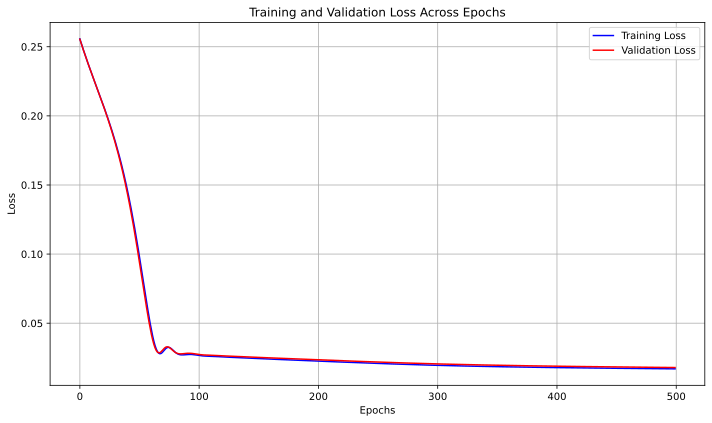

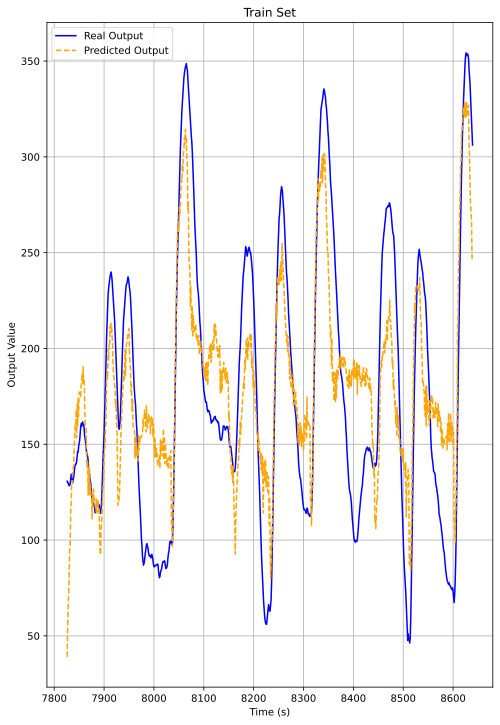

In [9]:
# --------------Plot identification results for G-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)
REN_0.to("cpu"); REN_1.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time:
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
    u0_batch, u1_batch, y_batch = u0_batch.to("cpu"), u1_batch.to("cpu"), y_batch.to("cpu")
    # Plot comparison between real and predicted for training set
    REN_0.eval(); REN_1.eval()

    y0_hat = REN_0(u0_batch)
    y1_hat = REN_1(u1_batch)# select the correct U
    y_hat = y0_hat - y1_hat
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S

y_init = x0


REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)
Dual_REN = DualREN(REN_0, REN_S, device=device)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_1 = ClosedLoopSystem(closed_loop_REN, controller)



#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam(Dual_REN.parameters(), lr=learning_rate)
optimizer.zero_grad()

In [11]:
#--------------------------5. Training---------------------------------------------------------------------


REN_0 = REN_0.to(device)
REN_S = REN_S.to(device)
Dual_Ren = Dual_REN.to(device)
controller = controller.to(device)
closed_loop_REN = closed_loop_REN.to(device)
x0 = x0.to(device)
print(f"[INFO] Training on device: {device}")

closed_loop_closed_loop_1 = closed_loop_closed_loop_1.to("cpu") # test always on cpu?
torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs

for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    closed_loop_REN.train()
    loss_epoch = 0.0  # Accumulate training loss


    for u0_batch, _, _, u1_batch, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        
        u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
        u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension

        optimizer.zero_grad()
        
        Dual_REN.reset(); 
        # closed_loop_REN.reset() ?
        
        _, y_hat_train = closed_loop_REN(x0, u_batch)

        if torch.isnan(y_hat_train).any() or torch.isinf(y_hat_train).any():
            y_hat_train = torch.nan_to_num(y_hat_train, nan=1e5, posinf=1e5, neginf=-1e5)
            for name, param in closed_loop_REN.named_parameters():
                print(f"{name}: mean {param.data.mean()}, std {param.data.std()}")

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()

        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    Dual_REN.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
            u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
            u_batch, y_batch = u_batch.to(device), y_batch.to(device)
            
            Dual_REN.reset(); 

            _, y_hat_val = closed_loop_REN(x0, u_batch)
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_Dual_REN = Dual_REN

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_Dual_REN_cpu = candidate_Dual_REN.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_2" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'Dueal_REN_state_dict': candidate_Dual_REN_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})

[INFO] Training on device: cpu


C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\env_non_lin_sys_id\Lib\site-packages\torch\utils\_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Epoch: 1 	||	 Training Loss: 0.131602 	||	 Validation Loss: 0.128249


Epoch: 2 	||	 Training Loss: 0.127171 	||	 Validation Loss: 0.125214


Epoch: 3 	||	 Training Loss: 0.122983 	||	 Validation Loss: 0.120608


Epoch: 4 	||	 Training Loss: 0.117874 	||	 Validation Loss: 0.116876


Epoch: 5 	||	 Training Loss: 0.113781 	||	 Validation Loss: 0.111010


Epoch: 6 	||	 Training Loss: 0.109579 	||	 Validation Loss: 0.107064


Epoch: 7 	||	 Training Loss: 0.105149 	||	 Validation Loss: 0.102591


Epoch: 8 	||	 Training Loss: 0.101447 	||	 Validation Loss: 0.099266


Epoch: 9 	||	 Training Loss: 0.097140 	||	 Validation Loss: 0.094596


Epoch: 10 	||	 Training Loss: 0.092823 	||	 Validation Loss: 0.090273


Epoch: 11 	||	 Training Loss: 0.088962 	||	 Validation Loss: 0.086181


Epoch: 12 	||	 Training Loss: 0.084802 	||	 Validation Loss: 0.082744


Epoch: 13 	||	 Training Loss: 0.080849 	||	 Validation Loss: 0.079231


Epoch: 14 	||	 Training Loss: 0.076962 	||	 Validation Loss: 0.075618


Epoch: 15 	||	 Training Loss: 0.073472 	||	 Validation Loss: 0.071227


Epoch: 16 	||	 Training Loss: 0.070196 	||	 Validation Loss: 0.067990


Epoch: 17 	||	 Training Loss: 0.066648 	||	 Validation Loss: 0.064478


Epoch: 18 	||	 Training Loss: 0.063207 	||	 Validation Loss: 0.061540


Epoch: 19 	||	 Training Loss: 0.060237 	||	 Validation Loss: 0.058345


Epoch: 20 	||	 Training Loss: 0.057367 	||	 Validation Loss: 0.055859


Epoch: 21 	||	 Training Loss: 0.054499 	||	 Validation Loss: 0.052997


Epoch: 22 	||	 Training Loss: 0.052093 	||	 Validation Loss: 0.051318


Epoch: 23 	||	 Training Loss: 0.049861 	||	 Validation Loss: 0.048930


Epoch: 24 	||	 Training Loss: 0.048377 	||	 Validation Loss: 0.047174


Epoch: 25 	||	 Training Loss: 0.046702 	||	 Validation Loss: 0.045741


Epoch: 26 	||	 Training Loss: 0.045357 	||	 Validation Loss: 0.044280


Epoch: 27 	||	 Training Loss: 0.044338 	||	 Validation Loss: 0.043626


Epoch: 28 	||	 Training Loss: 0.043266 	||	 Validation Loss: 0.043552


Epoch: 29 	||	 Training Loss: 0.042641 	||	 Validation Loss: 0.043668


Epoch: 30 	||	 Training Loss: 0.042564 	||	 Validation Loss: 0.043566


Epoch: 31 	||	 Training Loss: 0.042502 	||	 Validation Loss: 0.043060


Epoch: 32 	||	 Training Loss: 0.042581 	||	 Validation Loss: 0.043510


Epoch: 33 	||	 Training Loss: 0.042737 	||	 Validation Loss: 0.043491


Epoch: 34 	||	 Training Loss: 0.043120 	||	 Validation Loss: 0.043944


Epoch: 35 	||	 Training Loss: 0.043204 	||	 Validation Loss: 0.044168


Epoch: 36 	||	 Training Loss: 0.043425 	||	 Validation Loss: 0.043674


Epoch: 37 	||	 Training Loss: 0.043565 	||	 Validation Loss: 0.044813


Epoch: 38 	||	 Training Loss: 0.043666 	||	 Validation Loss: 0.044591


Epoch: 39 	||	 Training Loss: 0.043692 	||	 Validation Loss: 0.044026


Epoch: 40 	||	 Training Loss: 0.043505 	||	 Validation Loss: 0.043322


Epoch: 41 	||	 Training Loss: 0.043272 	||	 Validation Loss: 0.043560


Epoch: 42 	||	 Training Loss: 0.043053 	||	 Validation Loss: 0.043816


Epoch: 43 	||	 Training Loss: 0.042564 	||	 Validation Loss: 0.042957


Epoch: 44 	||	 Training Loss: 0.042350 	||	 Validation Loss: 0.042569


Epoch: 45 	||	 Training Loss: 0.041909 	||	 Validation Loss: 0.041976


Epoch: 46 	||	 Training Loss: 0.041498 	||	 Validation Loss: 0.041129


Epoch: 47 	||	 Training Loss: 0.041162 	||	 Validation Loss: 0.041616


Epoch: 48 	||	 Training Loss: 0.040811 	||	 Validation Loss: 0.040815


Epoch: 49 	||	 Training Loss: 0.040480 	||	 Validation Loss: 0.040964


Epoch: 50 	||	 Training Loss: 0.040252 	||	 Validation Loss: 0.040353


Epoch: 51 	||	 Training Loss: 0.040004 	||	 Validation Loss: 0.040637


Epoch: 52 	||	 Training Loss: 0.039828 	||	 Validation Loss: 0.040282


Epoch: 53 	||	 Training Loss: 0.039642 	||	 Validation Loss: 0.040420


Epoch: 54 	||	 Training Loss: 0.039563 	||	 Validation Loss: 0.040236


Epoch: 55 	||	 Training Loss: 0.039628 	||	 Validation Loss: 0.039975


Epoch: 56 	||	 Training Loss: 0.039430 	||	 Validation Loss: 0.039773


Epoch: 57 	||	 Training Loss: 0.039352 	||	 Validation Loss: 0.039794


Epoch: 58 	||	 Training Loss: 0.039283 	||	 Validation Loss: 0.040061


Epoch: 59 	||	 Training Loss: 0.039275 	||	 Validation Loss: 0.040098


Epoch: 60 	||	 Training Loss: 0.039250 	||	 Validation Loss: 0.039644


Epoch: 61 	||	 Training Loss: 0.039147 	||	 Validation Loss: 0.039800


Epoch: 62 	||	 Training Loss: 0.039180 	||	 Validation Loss: 0.039507


Epoch: 63 	||	 Training Loss: 0.039016 	||	 Validation Loss: 0.039726


Epoch: 64 	||	 Training Loss: 0.038993 	||	 Validation Loss: 0.039534


Epoch: 65 	||	 Training Loss: 0.038987 	||	 Validation Loss: 0.039479


Epoch: 66 	||	 Training Loss: 0.038804 	||	 Validation Loss: 0.039461


Epoch: 67 	||	 Training Loss: 0.038743 	||	 Validation Loss: 0.039391


Epoch: 68 	||	 Training Loss: 0.038752 	||	 Validation Loss: 0.039198


Epoch: 69 	||	 Training Loss: 0.038565 	||	 Validation Loss: 0.039183


Epoch: 70 	||	 Training Loss: 0.038500 	||	 Validation Loss: 0.039059


Epoch: 71 	||	 Training Loss: 0.038443 	||	 Validation Loss: 0.039084


Epoch: 72 	||	 Training Loss: 0.038325 	||	 Validation Loss: 0.038971


Epoch: 73 	||	 Training Loss: 0.038255 	||	 Validation Loss: 0.038893


Epoch: 74 	||	 Training Loss: 0.038264 	||	 Validation Loss: 0.038599


Epoch: 75 	||	 Training Loss: 0.038172 	||	 Validation Loss: 0.038642


Epoch: 76 	||	 Training Loss: 0.038081 	||	 Validation Loss: 0.038622


Epoch: 77 	||	 Training Loss: 0.038035 	||	 Validation Loss: 0.038536


Epoch: 78 	||	 Training Loss: 0.038003 	||	 Validation Loss: 0.038744


Epoch: 79 	||	 Training Loss: 0.037947 	||	 Validation Loss: 0.038782


Epoch: 80 	||	 Training Loss: 0.037894 	||	 Validation Loss: 0.038558


Epoch: 81 	||	 Training Loss: 0.037870 	||	 Validation Loss: 0.038683


Epoch: 82 	||	 Training Loss: 0.037771 	||	 Validation Loss: 0.038580


Epoch: 83 	||	 Training Loss: 0.037767 	||	 Validation Loss: 0.038236


Epoch: 84 	||	 Training Loss: 0.037686 	||	 Validation Loss: 0.038326


Epoch: 85 	||	 Training Loss: 0.037712 	||	 Validation Loss: 0.038288


Epoch: 86 	||	 Training Loss: 0.037509 	||	 Validation Loss: 0.037802


Epoch: 87 	||	 Training Loss: 0.037547 	||	 Validation Loss: 0.037976


Epoch: 88 	||	 Training Loss: 0.037472 	||	 Validation Loss: 0.037933


Epoch: 89 	||	 Training Loss: 0.037343 	||	 Validation Loss: 0.037813


Epoch: 90 	||	 Training Loss: 0.037268 	||	 Validation Loss: 0.037921


Epoch: 91 	||	 Training Loss: 0.037248 	||	 Validation Loss: 0.037951


Epoch: 92 	||	 Training Loss: 0.037273 	||	 Validation Loss: 0.037555


Epoch: 93 	||	 Training Loss: 0.037127 	||	 Validation Loss: 0.037584


Epoch: 94 	||	 Training Loss: 0.037107 	||	 Validation Loss: 0.037646


Epoch: 95 	||	 Training Loss: 0.037051 	||	 Validation Loss: 0.037501


Epoch: 96 	||	 Training Loss: 0.036976 	||	 Validation Loss: 0.037383


Epoch: 97 	||	 Training Loss: 0.036983 	||	 Validation Loss: 0.037481


Epoch: 98 	||	 Training Loss: 0.036956 	||	 Validation Loss: 0.037290


Epoch: 99 	||	 Training Loss: 0.036991 	||	 Validation Loss: 0.037308


Epoch: 100 	||	 Training Loss: 0.036844 	||	 Validation Loss: 0.037200


Epoch: 101 	||	 Training Loss: 0.036685 	||	 Validation Loss: 0.037371


Epoch: 102 	||	 Training Loss: 0.036721 	||	 Validation Loss: 0.037192


Epoch: 103 	||	 Training Loss: 0.036598 	||	 Validation Loss: 0.037170


Epoch: 104 	||	 Training Loss: 0.036624 	||	 Validation Loss: 0.037138


Epoch: 105 	||	 Training Loss: 0.036601 	||	 Validation Loss: 0.036879


Epoch: 106 	||	 Training Loss: 0.036545 	||	 Validation Loss: 0.036825


Epoch: 107 	||	 Training Loss: 0.036537 	||	 Validation Loss: 0.037016


Epoch: 108 	||	 Training Loss: 0.036412 	||	 Validation Loss: 0.036925


Epoch: 109 	||	 Training Loss: 0.036344 	||	 Validation Loss: 0.037135


Epoch: 110 	||	 Training Loss: 0.036300 	||	 Validation Loss: 0.036862


Epoch: 111 	||	 Training Loss: 0.036347 	||	 Validation Loss: 0.036617


Epoch: 112 	||	 Training Loss: 0.036286 	||	 Validation Loss: 0.036809


Epoch: 113 	||	 Training Loss: 0.036251 	||	 Validation Loss: 0.036597


Epoch: 114 	||	 Training Loss: 0.036202 	||	 Validation Loss: 0.036761


Epoch: 115 	||	 Training Loss: 0.036147 	||	 Validation Loss: 0.036685


Epoch: 116 	||	 Training Loss: 0.036114 	||	 Validation Loss: 0.036592


Epoch: 117 	||	 Training Loss: 0.036071 	||	 Validation Loss: 0.036413


Epoch: 118 	||	 Training Loss: 0.036021 	||	 Validation Loss: 0.036412


Epoch: 119 	||	 Training Loss: 0.035890 	||	 Validation Loss: 0.036373


Epoch: 120 	||	 Training Loss: 0.035923 	||	 Validation Loss: 0.036521


Epoch: 121 	||	 Training Loss: 0.035874 	||	 Validation Loss: 0.036219


Epoch: 122 	||	 Training Loss: 0.035810 	||	 Validation Loss: 0.036311


Epoch: 123 	||	 Training Loss: 0.035745 	||	 Validation Loss: 0.036278


Epoch: 124 	||	 Training Loss: 0.035716 	||	 Validation Loss: 0.036330


Epoch: 125 	||	 Training Loss: 0.035660 	||	 Validation Loss: 0.035967


Epoch: 126 	||	 Training Loss: 0.035642 	||	 Validation Loss: 0.035942


Epoch: 127 	||	 Training Loss: 0.035591 	||	 Validation Loss: 0.036257


Epoch: 128 	||	 Training Loss: 0.035558 	||	 Validation Loss: 0.036001


Epoch: 129 	||	 Training Loss: 0.035564 	||	 Validation Loss: 0.036092


Epoch: 130 	||	 Training Loss: 0.035530 	||	 Validation Loss: 0.036237


Epoch: 131 	||	 Training Loss: 0.035411 	||	 Validation Loss: 0.036057


Epoch: 132 	||	 Training Loss: 0.035381 	||	 Validation Loss: 0.035928


Epoch: 133 	||	 Training Loss: 0.035323 	||	 Validation Loss: 0.035859


Epoch: 134 	||	 Training Loss: 0.035291 	||	 Validation Loss: 0.035947


Epoch: 135 	||	 Training Loss: 0.035265 	||	 Validation Loss: 0.035778


Epoch: 136 	||	 Training Loss: 0.035163 	||	 Validation Loss: 0.035842


Epoch: 137 	||	 Training Loss: 0.035176 	||	 Validation Loss: 0.035811


Epoch: 138 	||	 Training Loss: 0.035114 	||	 Validation Loss: 0.035605


Epoch: 139 	||	 Training Loss: 0.035025 	||	 Validation Loss: 0.035624


Epoch: 140 	||	 Training Loss: 0.035027 	||	 Validation Loss: 0.035562


Epoch: 141 	||	 Training Loss: 0.034946 	||	 Validation Loss: 0.035510


Epoch: 142 	||	 Training Loss: 0.034996 	||	 Validation Loss: 0.035594


Epoch: 143 	||	 Training Loss: 0.034872 	||	 Validation Loss: 0.035605


Epoch: 144 	||	 Training Loss: 0.034850 	||	 Validation Loss: 0.035480


Epoch: 145 	||	 Training Loss: 0.034796 	||	 Validation Loss: 0.035430


Epoch: 146 	||	 Training Loss: 0.034746 	||	 Validation Loss: 0.035253


Epoch: 147 	||	 Training Loss: 0.034704 	||	 Validation Loss: 0.035418


Epoch: 148 	||	 Training Loss: 0.034701 	||	 Validation Loss: 0.035261


Epoch: 149 	||	 Training Loss: 0.034688 	||	 Validation Loss: 0.035251


Epoch: 150 	||	 Training Loss: 0.034619 	||	 Validation Loss: 0.035200


Epoch: 151 	||	 Training Loss: 0.034622 	||	 Validation Loss: 0.035086


Epoch: 152 	||	 Training Loss: 0.034569 	||	 Validation Loss: 0.035055


Epoch: 153 	||	 Training Loss: 0.034508 	||	 Validation Loss: 0.035033


Epoch: 154 	||	 Training Loss: 0.034452 	||	 Validation Loss: 0.035014


Epoch: 155 	||	 Training Loss: 0.034441 	||	 Validation Loss: 0.035052


Epoch: 156 	||	 Training Loss: 0.034337 	||	 Validation Loss: 0.034976


Epoch: 157 	||	 Training Loss: 0.034385 	||	 Validation Loss: 0.034827


Epoch: 158 	||	 Training Loss: 0.034299 	||	 Validation Loss: 0.034994


Epoch: 159 	||	 Training Loss: 0.034287 	||	 Validation Loss: 0.034843


Epoch: 160 	||	 Training Loss: 0.034253 	||	 Validation Loss: 0.034704


Epoch: 161 	||	 Training Loss: 0.034210 	||	 Validation Loss: 0.034638


Epoch: 162 	||	 Training Loss: 0.034154 	||	 Validation Loss: 0.034787


Epoch: 163 	||	 Training Loss: 0.034070 	||	 Validation Loss: 0.034533


Epoch: 164 	||	 Training Loss: 0.034045 	||	 Validation Loss: 0.034324


Epoch: 165 	||	 Training Loss: 0.034040 	||	 Validation Loss: 0.034501


Epoch: 166 	||	 Training Loss: 0.033995 	||	 Validation Loss: 0.034463


Epoch: 167 	||	 Training Loss: 0.033927 	||	 Validation Loss: 0.034440


Epoch: 168 	||	 Training Loss: 0.033883 	||	 Validation Loss: 0.034342


Epoch: 169 	||	 Training Loss: 0.033872 	||	 Validation Loss: 0.034289


Epoch: 170 	||	 Training Loss: 0.033856 	||	 Validation Loss: 0.034311


Epoch: 171 	||	 Training Loss: 0.033830 	||	 Validation Loss: 0.034326


Epoch: 172 	||	 Training Loss: 0.033775 	||	 Validation Loss: 0.034266


Epoch: 173 	||	 Training Loss: 0.033719 	||	 Validation Loss: 0.034353


Epoch: 174 	||	 Training Loss: 0.033675 	||	 Validation Loss: 0.034285


Epoch: 175 	||	 Training Loss: 0.033665 	||	 Validation Loss: 0.034025


Epoch: 176 	||	 Training Loss: 0.033606 	||	 Validation Loss: 0.034036


Epoch: 177 	||	 Training Loss: 0.033573 	||	 Validation Loss: 0.034166


Epoch: 178 	||	 Training Loss: 0.033558 	||	 Validation Loss: 0.034068


Epoch: 179 	||	 Training Loss: 0.033476 	||	 Validation Loss: 0.034169


Epoch: 180 	||	 Training Loss: 0.033465 	||	 Validation Loss: 0.034005


Epoch: 181 	||	 Training Loss: 0.033415 	||	 Validation Loss: 0.033896


Epoch: 182 	||	 Training Loss: 0.033327 	||	 Validation Loss: 0.033896


Epoch: 183 	||	 Training Loss: 0.033399 	||	 Validation Loss: 0.033871


Epoch: 184 	||	 Training Loss: 0.033348 	||	 Validation Loss: 0.033763


Epoch: 185 	||	 Training Loss: 0.033287 	||	 Validation Loss: 0.033673


Epoch: 186 	||	 Training Loss: 0.033261 	||	 Validation Loss: 0.033694


Epoch: 187 	||	 Training Loss: 0.033214 	||	 Validation Loss: 0.033688


Epoch: 188 	||	 Training Loss: 0.033136 	||	 Validation Loss: 0.033672


Epoch: 189 	||	 Training Loss: 0.033122 	||	 Validation Loss: 0.033647


Epoch: 190 	||	 Training Loss: 0.033066 	||	 Validation Loss: 0.033537


Epoch: 191 	||	 Training Loss: 0.033087 	||	 Validation Loss: 0.033632


Epoch: 192 	||	 Training Loss: 0.032993 	||	 Validation Loss: 0.033626


Epoch: 193 	||	 Training Loss: 0.033014 	||	 Validation Loss: 0.033415


Epoch: 194 	||	 Training Loss: 0.032980 	||	 Validation Loss: 0.033585


Epoch: 195 	||	 Training Loss: 0.032903 	||	 Validation Loss: 0.033496


Epoch: 196 	||	 Training Loss: 0.032859 	||	 Validation Loss: 0.033485


Epoch: 197 	||	 Training Loss: 0.032795 	||	 Validation Loss: 0.033453


Epoch: 198 	||	 Training Loss: 0.032776 	||	 Validation Loss: 0.033418


Epoch: 199 	||	 Training Loss: 0.032766 	||	 Validation Loss: 0.033301


Epoch: 200 	||	 Training Loss: 0.032738 	||	 Validation Loss: 0.033391


Epoch: 201 	||	 Training Loss: 0.032683 	||	 Validation Loss: 0.033211


Epoch: 202 	||	 Training Loss: 0.032603 	||	 Validation Loss: 0.033221


Epoch: 203 	||	 Training Loss: 0.032622 	||	 Validation Loss: 0.033168


Epoch: 204 	||	 Training Loss: 0.032558 	||	 Validation Loss: 0.033148


Epoch: 205 	||	 Training Loss: 0.032525 	||	 Validation Loss: 0.033094


Epoch: 206 	||	 Training Loss: 0.032508 	||	 Validation Loss: 0.033100


Epoch: 207 	||	 Training Loss: 0.032494 	||	 Validation Loss: 0.032942


Epoch: 208 	||	 Training Loss: 0.032469 	||	 Validation Loss: 0.033081


Epoch: 209 	||	 Training Loss: 0.032391 	||	 Validation Loss: 0.033054


Epoch: 210 	||	 Training Loss: 0.032428 	||	 Validation Loss: 0.032946


Epoch: 211 	||	 Training Loss: 0.032412 	||	 Validation Loss: 0.032969


Epoch: 212 	||	 Training Loss: 0.032315 	||	 Validation Loss: 0.032871


Epoch: 213 	||	 Training Loss: 0.032302 	||	 Validation Loss: 0.032852


Epoch: 214 	||	 Training Loss: 0.032278 	||	 Validation Loss: 0.032842


Epoch: 215 	||	 Training Loss: 0.032224 	||	 Validation Loss: 0.032990


Epoch: 216 	||	 Training Loss: 0.032171 	||	 Validation Loss: 0.032762


Epoch: 217 	||	 Training Loss: 0.032140 	||	 Validation Loss: 0.032664


Epoch: 218 	||	 Training Loss: 0.032050 	||	 Validation Loss: 0.032588


Epoch: 219 	||	 Training Loss: 0.032032 	||	 Validation Loss: 0.032714


Epoch: 220 	||	 Training Loss: 0.032012 	||	 Validation Loss: 0.032591


Epoch: 221 	||	 Training Loss: 0.031985 	||	 Validation Loss: 0.032559


Epoch: 222 	||	 Training Loss: 0.031921 	||	 Validation Loss: 0.032441


Epoch: 223 	||	 Training Loss: 0.031922 	||	 Validation Loss: 0.032450


Epoch: 224 	||	 Training Loss: 0.031855 	||	 Validation Loss: 0.032421


Epoch: 225 	||	 Training Loss: 0.031874 	||	 Validation Loss: 0.032432


Epoch: 226 	||	 Training Loss: 0.031788 	||	 Validation Loss: 0.032321


Epoch: 227 	||	 Training Loss: 0.031787 	||	 Validation Loss: 0.032401


Epoch: 228 	||	 Training Loss: 0.031768 	||	 Validation Loss: 0.032324


Epoch: 229 	||	 Training Loss: 0.031741 	||	 Validation Loss: 0.032241


Epoch: 230 	||	 Training Loss: 0.031673 	||	 Validation Loss: 0.032214


Epoch: 231 	||	 Training Loss: 0.031668 	||	 Validation Loss: 0.032134


Epoch: 232 	||	 Training Loss: 0.031649 	||	 Validation Loss: 0.032292


Epoch: 233 	||	 Training Loss: 0.031588 	||	 Validation Loss: 0.032163


Epoch: 234 	||	 Training Loss: 0.031546 	||	 Validation Loss: 0.032078


Epoch: 235 	||	 Training Loss: 0.031551 	||	 Validation Loss: 0.032092


Epoch: 236 	||	 Training Loss: 0.031483 	||	 Validation Loss: 0.031965


Epoch: 237 	||	 Training Loss: 0.031478 	||	 Validation Loss: 0.032085


Epoch: 238 	||	 Training Loss: 0.031456 	||	 Validation Loss: 0.032024


Epoch: 239 	||	 Training Loss: 0.031421 	||	 Validation Loss: 0.031975


Epoch: 240 	||	 Training Loss: 0.031386 	||	 Validation Loss: 0.031954


Epoch: 241 	||	 Training Loss: 0.031351 	||	 Validation Loss: 0.031909


Epoch: 242 	||	 Training Loss: 0.031344 	||	 Validation Loss: 0.031918


Epoch: 243 	||	 Training Loss: 0.031275 	||	 Validation Loss: 0.031852


Epoch: 244 	||	 Training Loss: 0.031261 	||	 Validation Loss: 0.031862


Epoch: 245 	||	 Training Loss: 0.031228 	||	 Validation Loss: 0.031878


Epoch: 246 	||	 Training Loss: 0.031224 	||	 Validation Loss: 0.032010


Epoch: 247 	||	 Training Loss: 0.031178 	||	 Validation Loss: 0.031743


Epoch: 248 	||	 Training Loss: 0.031160 	||	 Validation Loss: 0.031807


Epoch: 249 	||	 Training Loss: 0.031131 	||	 Validation Loss: 0.031741


Epoch: 250 	||	 Training Loss: 0.031094 	||	 Validation Loss: 0.031676


Epoch: 251 	||	 Training Loss: 0.031035 	||	 Validation Loss: 0.031713


Epoch: 252 	||	 Training Loss: 0.031017 	||	 Validation Loss: 0.031714


Epoch: 253 	||	 Training Loss: 0.031015 	||	 Validation Loss: 0.031618


Epoch: 254 	||	 Training Loss: 0.031004 	||	 Validation Loss: 0.031714


Epoch: 255 	||	 Training Loss: 0.031014 	||	 Validation Loss: 0.031576


Epoch: 256 	||	 Training Loss: 0.030917 	||	 Validation Loss: 0.031646


Epoch: 257 	||	 Training Loss: 0.030929 	||	 Validation Loss: 0.031594


Epoch: 258 	||	 Training Loss: 0.030898 	||	 Validation Loss: 0.031748


Epoch: 259 	||	 Training Loss: 0.030858 	||	 Validation Loss: 0.031554


Epoch: 260 	||	 Training Loss: 0.030830 	||	 Validation Loss: 0.031580


Epoch: 261 	||	 Training Loss: 0.030766 	||	 Validation Loss: 0.031538


Epoch: 262 	||	 Training Loss: 0.030764 	||	 Validation Loss: 0.031485


Epoch: 263 	||	 Training Loss: 0.030727 	||	 Validation Loss: 0.031440


Epoch: 264 	||	 Training Loss: 0.030754 	||	 Validation Loss: 0.031361


Epoch: 265 	||	 Training Loss: 0.030728 	||	 Validation Loss: 0.031406


Epoch: 266 	||	 Training Loss: 0.030697 	||	 Validation Loss: 0.031403


Epoch: 267 	||	 Training Loss: 0.030649 	||	 Validation Loss: 0.031467


Epoch: 268 	||	 Training Loss: 0.030634 	||	 Validation Loss: 0.031464


Epoch: 269 	||	 Training Loss: 0.030636 	||	 Validation Loss: 0.031389


Epoch: 270 	||	 Training Loss: 0.030601 	||	 Validation Loss: 0.031314


Epoch: 271 	||	 Training Loss: 0.030543 	||	 Validation Loss: 0.031352


Epoch: 272 	||	 Training Loss: 0.030526 	||	 Validation Loss: 0.031326


Epoch: 273 	||	 Training Loss: 0.030517 	||	 Validation Loss: 0.031365


Epoch: 274 	||	 Training Loss: 0.030501 	||	 Validation Loss: 0.031217


Epoch: 275 	||	 Training Loss: 0.030448 	||	 Validation Loss: 0.031333


Epoch: 276 	||	 Training Loss: 0.030436 	||	 Validation Loss: 0.031130


Epoch: 277 	||	 Training Loss: 0.030426 	||	 Validation Loss: 0.031296


Epoch: 278 	||	 Training Loss: 0.030401 	||	 Validation Loss: 0.031056


Epoch: 279 	||	 Training Loss: 0.030372 	||	 Validation Loss: 0.031118


Epoch: 280 	||	 Training Loss: 0.030360 	||	 Validation Loss: 0.031153


Epoch: 281 	||	 Training Loss: 0.030275 	||	 Validation Loss: 0.031117


Epoch: 282 	||	 Training Loss: 0.030304 	||	 Validation Loss: 0.031079


Epoch: 283 	||	 Training Loss: 0.030290 	||	 Validation Loss: 0.031082


Epoch: 284 	||	 Training Loss: 0.030255 	||	 Validation Loss: 0.031091


Epoch: 285 	||	 Training Loss: 0.030221 	||	 Validation Loss: 0.031005


Epoch: 286 	||	 Training Loss: 0.030191 	||	 Validation Loss: 0.031008


Epoch: 287 	||	 Training Loss: 0.030175 	||	 Validation Loss: 0.030906


Epoch: 288 	||	 Training Loss: 0.030179 	||	 Validation Loss: 0.030998


Epoch: 289 	||	 Training Loss: 0.030139 	||	 Validation Loss: 0.030925


Epoch: 290 	||	 Training Loss: 0.030134 	||	 Validation Loss: 0.030922


Epoch: 291 	||	 Training Loss: 0.030112 	||	 Validation Loss: 0.030936


Epoch: 292 	||	 Training Loss: 0.030049 	||	 Validation Loss: 0.030936


Epoch: 293 	||	 Training Loss: 0.030040 	||	 Validation Loss: 0.030837


Epoch: 294 	||	 Training Loss: 0.030031 	||	 Validation Loss: 0.030791


Epoch: 295 	||	 Training Loss: 0.029978 	||	 Validation Loss: 0.030851


Epoch: 296 	||	 Training Loss: 0.029942 	||	 Validation Loss: 0.030902


Epoch: 297 	||	 Training Loss: 0.029972 	||	 Validation Loss: 0.030782


Epoch: 298 	||	 Training Loss: 0.029908 	||	 Validation Loss: 0.030778


Epoch: 299 	||	 Training Loss: 0.029900 	||	 Validation Loss: 0.030808


Epoch: 300 	||	 Training Loss: 0.029861 	||	 Validation Loss: 0.030766


Epoch: 301 	||	 Training Loss: 0.029839 	||	 Validation Loss: 0.030644


Epoch: 302 	||	 Training Loss: 0.029807 	||	 Validation Loss: 0.030713


Epoch: 303 	||	 Training Loss: 0.029793 	||	 Validation Loss: 0.030659


Epoch: 304 	||	 Training Loss: 0.029761 	||	 Validation Loss: 0.030648


Epoch: 305 	||	 Training Loss: 0.029738 	||	 Validation Loss: 0.030614


Epoch: 306 	||	 Training Loss: 0.029734 	||	 Validation Loss: 0.030611


Epoch: 307 	||	 Training Loss: 0.029691 	||	 Validation Loss: 0.030554


Epoch: 308 	||	 Training Loss: 0.029667 	||	 Validation Loss: 0.030544


Epoch: 309 	||	 Training Loss: 0.029636 	||	 Validation Loss: 0.030405


Epoch: 310 	||	 Training Loss: 0.029603 	||	 Validation Loss: 0.030439


Epoch: 311 	||	 Training Loss: 0.029584 	||	 Validation Loss: 0.030396


Epoch: 312 	||	 Training Loss: 0.029565 	||	 Validation Loss: 0.030403


Epoch: 313 	||	 Training Loss: 0.029527 	||	 Validation Loss: 0.030421


Epoch: 314 	||	 Training Loss: 0.029506 	||	 Validation Loss: 0.030378


Epoch: 315 	||	 Training Loss: 0.029477 	||	 Validation Loss: 0.030341


Epoch: 316 	||	 Training Loss: 0.029427 	||	 Validation Loss: 0.030342


Epoch: 317 	||	 Training Loss: 0.029420 	||	 Validation Loss: 0.030260


Epoch: 318 	||	 Training Loss: 0.029386 	||	 Validation Loss: 0.030293


Epoch: 319 	||	 Training Loss: 0.029345 	||	 Validation Loss: 0.030229


Epoch: 320 	||	 Training Loss: 0.029316 	||	 Validation Loss: 0.030173


Epoch: 321 	||	 Training Loss: 0.029295 	||	 Validation Loss: 0.030218


Epoch: 322 	||	 Training Loss: 0.029273 	||	 Validation Loss: 0.030184


Epoch: 323 	||	 Training Loss: 0.029236 	||	 Validation Loss: 0.030129


Epoch: 324 	||	 Training Loss: 0.029203 	||	 Validation Loss: 0.030072


Epoch: 325 	||	 Training Loss: 0.029193 	||	 Validation Loss: 0.030123


Epoch: 326 	||	 Training Loss: 0.029147 	||	 Validation Loss: 0.030072


Epoch: 327 	||	 Training Loss: 0.029122 	||	 Validation Loss: 0.030061


Epoch: 328 	||	 Training Loss: 0.029078 	||	 Validation Loss: 0.029945


Epoch: 329 	||	 Training Loss: 0.029045 	||	 Validation Loss: 0.029894


Epoch: 330 	||	 Training Loss: 0.029028 	||	 Validation Loss: 0.029882


Epoch: 331 	||	 Training Loss: 0.029002 	||	 Validation Loss: 0.029873


Epoch: 332 	||	 Training Loss: 0.028957 	||	 Validation Loss: 0.029820


Epoch: 333 	||	 Training Loss: 0.028927 	||	 Validation Loss: 0.029811


Epoch: 334 	||	 Training Loss: 0.028924 	||	 Validation Loss: 0.029758


Epoch: 335 	||	 Training Loss: 0.028853 	||	 Validation Loss: 0.029730


Epoch: 336 	||	 Training Loss: 0.028843 	||	 Validation Loss: 0.029703


Epoch: 337 	||	 Training Loss: 0.028813 	||	 Validation Loss: 0.029698


Epoch: 338 	||	 Training Loss: 0.028760 	||	 Validation Loss: 0.029643


Epoch: 339 	||	 Training Loss: 0.028736 	||	 Validation Loss: 0.029630


Epoch: 340 	||	 Training Loss: 0.028684 	||	 Validation Loss: 0.029585


Epoch: 341 	||	 Training Loss: 0.028641 	||	 Validation Loss: 0.029575


Epoch: 342 	||	 Training Loss: 0.028616 	||	 Validation Loss: 0.029536


Epoch: 343 	||	 Training Loss: 0.028555 	||	 Validation Loss: 0.029485


Epoch: 344 	||	 Training Loss: 0.028539 	||	 Validation Loss: 0.029482


Epoch: 345 	||	 Training Loss: 0.028503 	||	 Validation Loss: 0.029448


Epoch: 346 	||	 Training Loss: 0.028467 	||	 Validation Loss: 0.029355


Epoch: 347 	||	 Training Loss: 0.028418 	||	 Validation Loss: 0.029379


Epoch: 348 	||	 Training Loss: 0.028373 	||	 Validation Loss: 0.029312


Epoch: 349 	||	 Training Loss: 0.028352 	||	 Validation Loss: 0.029282


Epoch: 350 	||	 Training Loss: 0.028297 	||	 Validation Loss: 0.029205


Epoch: 351 	||	 Training Loss: 0.028264 	||	 Validation Loss: 0.029238


Epoch: 352 	||	 Training Loss: 0.028205 	||	 Validation Loss: 0.029149


Epoch: 353 	||	 Training Loss: 0.028171 	||	 Validation Loss: 0.029104


Epoch: 354 	||	 Training Loss: 0.028132 	||	 Validation Loss: 0.029049


Epoch: 355 	||	 Training Loss: 0.028092 	||	 Validation Loss: 0.028965


Epoch: 356 	||	 Training Loss: 0.028040 	||	 Validation Loss: 0.028960


Epoch: 357 	||	 Training Loss: 0.027978 	||	 Validation Loss: 0.028877


Epoch: 358 	||	 Training Loss: 0.027930 	||	 Validation Loss: 0.028838


Epoch: 359 	||	 Training Loss: 0.027878 	||	 Validation Loss: 0.028796


Epoch: 360 	||	 Training Loss: 0.027835 	||	 Validation Loss: 0.028770


Epoch: 361 	||	 Training Loss: 0.027774 	||	 Validation Loss: 0.028676


Epoch: 362 	||	 Training Loss: 0.027722 	||	 Validation Loss: 0.028671


Epoch: 363 	||	 Training Loss: 0.027691 	||	 Validation Loss: 0.028621


Epoch: 364 	||	 Training Loss: 0.027646 	||	 Validation Loss: 0.028591


Epoch: 365 	||	 Training Loss: 0.027582 	||	 Validation Loss: 0.028532


Epoch: 366 	||	 Training Loss: 0.027521 	||	 Validation Loss: 0.028439


Epoch: 367 	||	 Training Loss: 0.027476 	||	 Validation Loss: 0.028421


Epoch: 368 	||	 Training Loss: 0.027417 	||	 Validation Loss: 0.028368


Epoch: 369 	||	 Training Loss: 0.027344 	||	 Validation Loss: 0.028292


Epoch: 370 	||	 Training Loss: 0.027314 	||	 Validation Loss: 0.028203


Epoch: 371 	||	 Training Loss: 0.027239 	||	 Validation Loss: 0.028197


Epoch: 372 	||	 Training Loss: 0.027163 	||	 Validation Loss: 0.028098


Epoch: 373 	||	 Training Loss: 0.027118 	||	 Validation Loss: 0.028042


Epoch: 374 	||	 Training Loss: 0.027047 	||	 Validation Loss: 0.027968


Epoch: 375 	||	 Training Loss: 0.026995 	||	 Validation Loss: 0.027934


Epoch: 376 	||	 Training Loss: 0.026932 	||	 Validation Loss: 0.027858


Epoch: 377 	||	 Training Loss: 0.026871 	||	 Validation Loss: 0.027790


Epoch: 378 	||	 Training Loss: 0.026808 	||	 Validation Loss: 0.027740


Epoch: 379 	||	 Training Loss: 0.026725 	||	 Validation Loss: 0.027649


Epoch: 380 	||	 Training Loss: 0.026650 	||	 Validation Loss: 0.027539


Epoch: 381 	||	 Training Loss: 0.026587 	||	 Validation Loss: 0.027530


Epoch: 382 	||	 Training Loss: 0.026503 	||	 Validation Loss: 0.027470


Epoch: 383 	||	 Training Loss: 0.026444 	||	 Validation Loss: 0.027394


Epoch: 384 	||	 Training Loss: 0.026359 	||	 Validation Loss: 0.027314


Epoch: 385 	||	 Training Loss: 0.026288 	||	 Validation Loss: 0.027225


Epoch: 386 	||	 Training Loss: 0.026206 	||	 Validation Loss: 0.027144


Epoch: 387 	||	 Training Loss: 0.026130 	||	 Validation Loss: 0.027053


Epoch: 388 	||	 Training Loss: 0.026051 	||	 Validation Loss: 0.027008


Epoch: 389 	||	 Training Loss: 0.025980 	||	 Validation Loss: 0.026921


Epoch: 390 	||	 Training Loss: 0.025877 	||	 Validation Loss: 0.026817


Epoch: 391 	||	 Training Loss: 0.025791 	||	 Validation Loss: 0.026728


Epoch: 392 	||	 Training Loss: 0.025721 	||	 Validation Loss: 0.026599


Epoch: 393 	||	 Training Loss: 0.025623 	||	 Validation Loss: 0.026546


Epoch: 394 	||	 Training Loss: 0.025524 	||	 Validation Loss: 0.026383


Epoch: 395 	||	 Training Loss: 0.025433 	||	 Validation Loss: 0.026288


Epoch: 396 	||	 Training Loss: 0.025349 	||	 Validation Loss: 0.026251


Epoch: 397 	||	 Training Loss: 0.025260 	||	 Validation Loss: 0.026145


Epoch: 398 	||	 Training Loss: 0.025143 	||	 Validation Loss: 0.026005


Epoch: 399 	||	 Training Loss: 0.025041 	||	 Validation Loss: 0.025929


Epoch: 400 	||	 Training Loss: 0.024957 	||	 Validation Loss: 0.025818


Epoch: 401 	||	 Training Loss: 0.024837 	||	 Validation Loss: 0.025701


Epoch: 402 	||	 Training Loss: 0.024731 	||	 Validation Loss: 0.025634


Epoch: 403 	||	 Training Loss: 0.024654 	||	 Validation Loss: 0.025474


Epoch: 404 	||	 Training Loss: 0.024534 	||	 Validation Loss: 0.025423


Epoch: 405 	||	 Training Loss: 0.024417 	||	 Validation Loss: 0.025250


Epoch: 406 	||	 Training Loss: 0.024318 	||	 Validation Loss: 0.025203


Epoch: 407 	||	 Training Loss: 0.024206 	||	 Validation Loss: 0.025082


Epoch: 408 	||	 Training Loss: 0.024097 	||	 Validation Loss: 0.024978


Epoch: 409 	||	 Training Loss: 0.023974 	||	 Validation Loss: 0.024829


Epoch: 410 	||	 Training Loss: 0.023858 	||	 Validation Loss: 0.024733


Epoch: 411 	||	 Training Loss: 0.023714 	||	 Validation Loss: 0.024567


Epoch: 412 	||	 Training Loss: 0.023595 	||	 Validation Loss: 0.024423


Epoch: 413 	||	 Training Loss: 0.023467 	||	 Validation Loss: 0.024301


Epoch: 414 	||	 Training Loss: 0.023325 	||	 Validation Loss: 0.024191


Epoch: 415 	||	 Training Loss: 0.023182 	||	 Validation Loss: 0.024071


Epoch: 416 	||	 Training Loss: 0.023071 	||	 Validation Loss: 0.023914


Epoch: 417 	||	 Training Loss: 0.022918 	||	 Validation Loss: 0.023856


Epoch: 418 	||	 Training Loss: 0.022781 	||	 Validation Loss: 0.023671


Epoch: 419 	||	 Training Loss: 0.022614 	||	 Validation Loss: 0.023539


Epoch: 420 	||	 Training Loss: 0.022526 	||	 Validation Loss: 0.023391


Epoch: 421 	||	 Training Loss: 0.022384 	||	 Validation Loss: 0.023230


Epoch: 422 	||	 Training Loss: 0.022205 	||	 Validation Loss: 0.023072


Epoch: 423 	||	 Training Loss: 0.022090 	||	 Validation Loss: 0.022915


Epoch: 424 	||	 Training Loss: 0.021924 	||	 Validation Loss: 0.022790


Epoch: 425 	||	 Training Loss: 0.021787 	||	 Validation Loss: 0.022678


Epoch: 426 	||	 Training Loss: 0.021629 	||	 Validation Loss: 0.022561


Epoch: 427 	||	 Training Loss: 0.021486 	||	 Validation Loss: 0.022398


Epoch: 428 	||	 Training Loss: 0.021328 	||	 Validation Loss: 0.022193


Epoch: 429 	||	 Training Loss: 0.021174 	||	 Validation Loss: 0.022049


Epoch: 430 	||	 Training Loss: 0.021034 	||	 Validation Loss: 0.021951


Epoch: 431 	||	 Training Loss: 0.020857 	||	 Validation Loss: 0.021842


Epoch: 432 	||	 Training Loss: 0.020697 	||	 Validation Loss: 0.021557


Epoch: 433 	||	 Training Loss: 0.020570 	||	 Validation Loss: 0.021508


Epoch: 434 	||	 Training Loss: 0.020421 	||	 Validation Loss: 0.021343


Epoch: 435 	||	 Training Loss: 0.020265 	||	 Validation Loss: 0.021220


Epoch: 436 	||	 Training Loss: 0.020086 	||	 Validation Loss: 0.020997


Epoch: 437 	||	 Training Loss: 0.019930 	||	 Validation Loss: 0.020851


Epoch: 438 	||	 Training Loss: 0.019771 	||	 Validation Loss: 0.020749


Epoch: 439 	||	 Training Loss: 0.019639 	||	 Validation Loss: 0.020546


Epoch: 440 	||	 Training Loss: 0.019451 	||	 Validation Loss: 0.020426


Epoch: 441 	||	 Training Loss: 0.019299 	||	 Validation Loss: 0.020260


Epoch: 442 	||	 Training Loss: 0.019173 	||	 Validation Loss: 0.020054


Epoch: 443 	||	 Training Loss: 0.018971 	||	 Validation Loss: 0.019942


Epoch: 444 	||	 Training Loss: 0.018837 	||	 Validation Loss: 0.019800


Epoch: 445 	||	 Training Loss: 0.018683 	||	 Validation Loss: 0.019661


Epoch: 446 	||	 Training Loss: 0.018526 	||	 Validation Loss: 0.019383


Epoch: 447 	||	 Training Loss: 0.018388 	||	 Validation Loss: 0.019261


Epoch: 448 	||	 Training Loss: 0.018231 	||	 Validation Loss: 0.019117


Epoch: 449 	||	 Training Loss: 0.018083 	||	 Validation Loss: 0.019009


Epoch: 450 	||	 Training Loss: 0.017925 	||	 Validation Loss: 0.018922


Epoch: 451 	||	 Training Loss: 0.017775 	||	 Validation Loss: 0.018759


Epoch: 452 	||	 Training Loss: 0.017633 	||	 Validation Loss: 0.018593


Epoch: 453 	||	 Training Loss: 0.017430 	||	 Validation Loss: 0.018469


Epoch: 454 	||	 Training Loss: 0.017324 	||	 Validation Loss: 0.018291


Epoch: 455 	||	 Training Loss: 0.017157 	||	 Validation Loss: 0.018101


Epoch: 456 	||	 Training Loss: 0.017015 	||	 Validation Loss: 0.018015


Epoch: 457 	||	 Training Loss: 0.016863 	||	 Validation Loss: 0.017852


Epoch: 458 	||	 Training Loss: 0.016695 	||	 Validation Loss: 0.017733


Epoch: 459 	||	 Training Loss: 0.016569 	||	 Validation Loss: 0.017605


Epoch: 460 	||	 Training Loss: 0.016441 	||	 Validation Loss: 0.017507


Epoch: 461 	||	 Training Loss: 0.016324 	||	 Validation Loss: 0.017268


Epoch: 462 	||	 Training Loss: 0.016181 	||	 Validation Loss: 0.017286


Epoch: 463 	||	 Training Loss: 0.016086 	||	 Validation Loss: 0.017121


Epoch: 464 	||	 Training Loss: 0.015964 	||	 Validation Loss: 0.017137


Epoch: 465 	||	 Training Loss: 0.015766 	||	 Validation Loss: 0.016925


Epoch: 466 	||	 Training Loss: 0.015644 	||	 Validation Loss: 0.016869


Epoch: 467 	||	 Training Loss: 0.015585 	||	 Validation Loss: 0.016669


Epoch: 468 	||	 Training Loss: 0.015468 	||	 Validation Loss: 0.016590


Epoch: 469 	||	 Training Loss: 0.015321 	||	 Validation Loss: 0.016602


Epoch: 470 	||	 Training Loss: 0.015206 	||	 Validation Loss: 0.016421


Epoch: 471 	||	 Training Loss: 0.015110 	||	 Validation Loss: 0.016352


Epoch: 472 	||	 Training Loss: 0.014957 	||	 Validation Loss: 0.016262


Epoch: 473 	||	 Training Loss: 0.014873 	||	 Validation Loss: 0.016134


Epoch: 474 	||	 Training Loss: 0.014790 	||	 Validation Loss: 0.016057


Epoch: 475 	||	 Training Loss: 0.014638 	||	 Validation Loss: 0.015976


Epoch: 476 	||	 Training Loss: 0.014594 	||	 Validation Loss: 0.015967


Epoch: 477 	||	 Training Loss: 0.014458 	||	 Validation Loss: 0.015933


Epoch: 478 	||	 Training Loss: 0.014345 	||	 Validation Loss: 0.015849


Epoch: 479 	||	 Training Loss: 0.014297 	||	 Validation Loss: 0.015570


Epoch: 480 	||	 Training Loss: 0.014230 	||	 Validation Loss: 0.015650


Epoch: 481 	||	 Training Loss: 0.014107 	||	 Validation Loss: 0.015464


Epoch: 482 	||	 Training Loss: 0.014070 	||	 Validation Loss: 0.015584


Epoch: 483 	||	 Training Loss: 0.013979 	||	 Validation Loss: 0.015573


Epoch: 484 	||	 Training Loss: 0.013928 	||	 Validation Loss: 0.015463


Epoch: 485 	||	 Training Loss: 0.013837 	||	 Validation Loss: 0.015537


Epoch: 486 	||	 Training Loss: 0.013763 	||	 Validation Loss: 0.015499


Epoch: 487 	||	 Training Loss: 0.013809 	||	 Validation Loss: 0.015307


Epoch: 488 	||	 Training Loss: 0.013684 	||	 Validation Loss: 0.015465


Epoch: 489 	||	 Training Loss: 0.013675 	||	 Validation Loss: 0.015479


Epoch: 490 	||	 Training Loss: 0.013597 	||	 Validation Loss: 0.015496


Epoch: 491 	||	 Training Loss: 0.013548 	||	 Validation Loss: 0.015230


Epoch: 492 	||	 Training Loss: 0.013497 	||	 Validation Loss: 0.015333


Epoch: 493 	||	 Training Loss: 0.013555 	||	 Validation Loss: 0.015284


Epoch: 494 	||	 Training Loss: 0.013434 	||	 Validation Loss: 0.015248


Epoch: 495 	||	 Training Loss: 0.013416 	||	 Validation Loss: 0.015349


Epoch: 496 	||	 Training Loss: 0.013411 	||	 Validation Loss: 0.015214


Epoch: 497 	||	 Training Loss: 0.013347 	||	 Validation Loss: 0.015265


Epoch: 498 	||	 Training Loss: 0.013343 	||	 Validation Loss: 0.015107


Epoch: 499 	||	 Training Loss: 0.013290 	||	 Validation Loss: 0.015181


Epoch: 500 	||	 Training Loss: 0.013286 	||	 Validation Loss: 0.015156


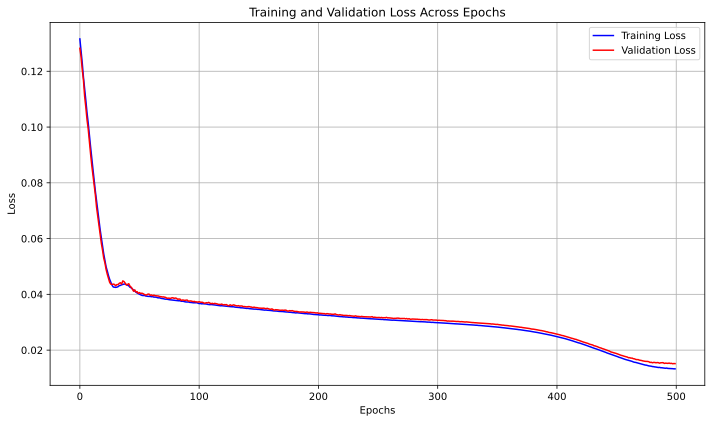

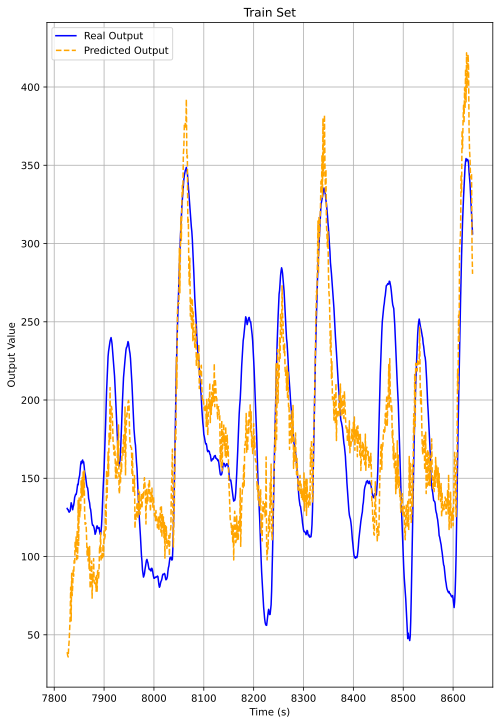

In [12]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

Dual_REN.to("cpu"); closed_loop_REN.to("cpu")
    

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch = u_batch.to("cpu"), y_batch.to("cpu")
    

    Dual_REN.eval()
    _, y_hat = closed_loop_REN(x0, u_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S
y_init = x0

REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S_2 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)


#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_S_2.parameters()),   lr=learning_rate)
optimizer.zero_grad()

In [14]:
#--------------------------5. Training---------------------------------------------------------------------

REN_0 = REN_0.to(device)
REN_S_2 = REN_S_2.to(device)
print(f"[INFO] Training on device: {device}")

torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs


for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_S_2.train()
    loss_epoch = 0.0  # Accumulate training loss

    for u0_batch, _, u1_batch, _, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        u0_batch, u1_batch, y_batch = ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()
        REN_0.reset(); REN_S_2.reset()
        
        
        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_S_2(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)
        
        loss_batch.backward()
        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_S_2.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, u1_batch, _, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_S_2.reset()
            
            y0_hat_val = REN_0(u0_batch) # forward
            y1_hat_val = REN_S_2(u1_batch) # forward
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_S_2 = REN_S_2

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_S_2_cpu = candidate_REN_S_2.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_3" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_S_2_state_dict': candidate_REN_S_2_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})
    
Dual_REN = DualREN(candidate_REN_0_cpu, candidate_REN_S_2_cpu)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN_2 = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_2 = ClosedLoopSystem(closed_loop_REN_2, controller)

[INFO] Training on device: cpu


Epoch: 1 	||	 Training Loss: 0.196360 	||	 Validation Loss: 0.197756


Epoch: 2 	||	 Training Loss: 0.196241 	||	 Validation Loss: 0.197652


Epoch: 3 	||	 Training Loss: 0.196124 	||	 Validation Loss: 0.197551


Epoch: 4 	||	 Training Loss: 0.196010 	||	 Validation Loss: 0.197453


Epoch: 5 	||	 Training Loss: 0.195899 	||	 Validation Loss: 0.197357


Epoch: 6 	||	 Training Loss: 0.195791 	||	 Validation Loss: 0.197263


Epoch: 7 	||	 Training Loss: 0.195685 	||	 Validation Loss: 0.197172


Epoch: 8 	||	 Training Loss: 0.195583 	||	 Validation Loss: 0.197084


Epoch: 9 	||	 Training Loss: 0.195483 	||	 Validation Loss: 0.196998


Epoch: 10 	||	 Training Loss: 0.195385 	||	 Validation Loss: 0.196914


Epoch: 11 	||	 Training Loss: 0.195291 	||	 Validation Loss: 0.196833


Epoch: 12 	||	 Training Loss: 0.195199 	||	 Validation Loss: 0.196754


Epoch: 13 	||	 Training Loss: 0.195110 	||	 Validation Loss: 0.196678


Epoch: 14 	||	 Training Loss: 0.195023 	||	 Validation Loss: 0.196604


Epoch: 15 	||	 Training Loss: 0.194939 	||	 Validation Loss: 0.196532


Epoch: 16 	||	 Training Loss: 0.194858 	||	 Validation Loss: 0.196463


Epoch: 17 	||	 Training Loss: 0.194779 	||	 Validation Loss: 0.196395


Epoch: 18 	||	 Training Loss: 0.194702 	||	 Validation Loss: 0.196330


Epoch: 19 	||	 Training Loss: 0.194628 	||	 Validation Loss: 0.196267


Epoch: 20 	||	 Training Loss: 0.194557 	||	 Validation Loss: 0.196206


Epoch: 21 	||	 Training Loss: 0.194487 	||	 Validation Loss: 0.196147


Epoch: 22 	||	 Training Loss: 0.194420 	||	 Validation Loss: 0.196090


Epoch: 23 	||	 Training Loss: 0.194355 	||	 Validation Loss: 0.196035


Epoch: 24 	||	 Training Loss: 0.194292 	||	 Validation Loss: 0.195982


Epoch: 25 	||	 Training Loss: 0.194231 	||	 Validation Loss: 0.195930


Epoch: 26 	||	 Training Loss: 0.194172 	||	 Validation Loss: 0.195880


Epoch: 27 	||	 Training Loss: 0.194115 	||	 Validation Loss: 0.195832


Epoch: 28 	||	 Training Loss: 0.194060 	||	 Validation Loss: 0.195785


Epoch: 29 	||	 Training Loss: 0.194006 	||	 Validation Loss: 0.195739


Epoch: 30 	||	 Training Loss: 0.193954 	||	 Validation Loss: 0.195695


Epoch: 31 	||	 Training Loss: 0.193904 	||	 Validation Loss: 0.195653


Epoch: 32 	||	 Training Loss: 0.193855 	||	 Validation Loss: 0.195612


Epoch: 33 	||	 Training Loss: 0.193808 	||	 Validation Loss: 0.195571


Epoch: 34 	||	 Training Loss: 0.193762 	||	 Validation Loss: 0.195532


Epoch: 35 	||	 Training Loss: 0.193717 	||	 Validation Loss: 0.195495


Epoch: 36 	||	 Training Loss: 0.193674 	||	 Validation Loss: 0.195458


Epoch: 37 	||	 Training Loss: 0.193632 	||	 Validation Loss: 0.195422


Epoch: 38 	||	 Training Loss: 0.193591 	||	 Validation Loss: 0.195387


Epoch: 39 	||	 Training Loss: 0.193550 	||	 Validation Loss: 0.195352


Epoch: 40 	||	 Training Loss: 0.193511 	||	 Validation Loss: 0.195319


Epoch: 41 	||	 Training Loss: 0.193473 	||	 Validation Loss: 0.195286


Epoch: 42 	||	 Training Loss: 0.193436 	||	 Validation Loss: 0.195254


Epoch: 43 	||	 Training Loss: 0.193399 	||	 Validation Loss: 0.195222


Epoch: 44 	||	 Training Loss: 0.193363 	||	 Validation Loss: 0.195191


Epoch: 45 	||	 Training Loss: 0.193328 	||	 Validation Loss: 0.195160


Epoch: 46 	||	 Training Loss: 0.193293 	||	 Validation Loss: 0.195130


Epoch: 47 	||	 Training Loss: 0.193259 	||	 Validation Loss: 0.195100


Epoch: 48 	||	 Training Loss: 0.193225 	||	 Validation Loss: 0.195071


Epoch: 49 	||	 Training Loss: 0.193192 	||	 Validation Loss: 0.195041


Epoch: 50 	||	 Training Loss: 0.193159 	||	 Validation Loss: 0.195012


Epoch: 51 	||	 Training Loss: 0.193126 	||	 Validation Loss: 0.194983


Epoch: 52 	||	 Training Loss: 0.193093 	||	 Validation Loss: 0.194954


Epoch: 53 	||	 Training Loss: 0.193061 	||	 Validation Loss: 0.194925


Epoch: 54 	||	 Training Loss: 0.193029 	||	 Validation Loss: 0.194896


Epoch: 55 	||	 Training Loss: 0.192997 	||	 Validation Loss: 0.194867


Epoch: 56 	||	 Training Loss: 0.192965 	||	 Validation Loss: 0.194837


Epoch: 57 	||	 Training Loss: 0.192933 	||	 Validation Loss: 0.194808


Epoch: 58 	||	 Training Loss: 0.192901 	||	 Validation Loss: 0.194778


Epoch: 59 	||	 Training Loss: 0.192869 	||	 Validation Loss: 0.194748


Epoch: 60 	||	 Training Loss: 0.192837 	||	 Validation Loss: 0.194718


Epoch: 61 	||	 Training Loss: 0.192804 	||	 Validation Loss: 0.194687


Epoch: 62 	||	 Training Loss: 0.192771 	||	 Validation Loss: 0.194655


Epoch: 63 	||	 Training Loss: 0.192738 	||	 Validation Loss: 0.194623


Epoch: 64 	||	 Training Loss: 0.192704 	||	 Validation Loss: 0.194591


Epoch: 65 	||	 Training Loss: 0.192670 	||	 Validation Loss: 0.194558


Epoch: 66 	||	 Training Loss: 0.192635 	||	 Validation Loss: 0.194523


Epoch: 67 	||	 Training Loss: 0.192599 	||	 Validation Loss: 0.194488


Epoch: 68 	||	 Training Loss: 0.192563 	||	 Validation Loss: 0.194452


Epoch: 69 	||	 Training Loss: 0.192525 	||	 Validation Loss: 0.194415


Epoch: 70 	||	 Training Loss: 0.192487 	||	 Validation Loss: 0.194377


Epoch: 71 	||	 Training Loss: 0.192448 	||	 Validation Loss: 0.194337


Epoch: 72 	||	 Training Loss: 0.192408 	||	 Validation Loss: 0.194296


Epoch: 73 	||	 Training Loss: 0.192366 	||	 Validation Loss: 0.194253


Epoch: 74 	||	 Training Loss: 0.192323 	||	 Validation Loss: 0.194209


Epoch: 75 	||	 Training Loss: 0.192278 	||	 Validation Loss: 0.194163


Epoch: 76 	||	 Training Loss: 0.192232 	||	 Validation Loss: 0.194115


Epoch: 77 	||	 Training Loss: 0.192184 	||	 Validation Loss: 0.194064


Epoch: 78 	||	 Training Loss: 0.192134 	||	 Validation Loss: 0.194011


Epoch: 79 	||	 Training Loss: 0.192081 	||	 Validation Loss: 0.193956


Epoch: 80 	||	 Training Loss: 0.192027 	||	 Validation Loss: 0.193898


Epoch: 81 	||	 Training Loss: 0.191969 	||	 Validation Loss: 0.193836


Epoch: 82 	||	 Training Loss: 0.191909 	||	 Validation Loss: 0.193771


Epoch: 83 	||	 Training Loss: 0.191845 	||	 Validation Loss: 0.193703


Epoch: 84 	||	 Training Loss: 0.191778 	||	 Validation Loss: 0.193630


Epoch: 85 	||	 Training Loss: 0.191707 	||	 Validation Loss: 0.193553


Epoch: 86 	||	 Training Loss: 0.191632 	||	 Validation Loss: 0.193471


Epoch: 87 	||	 Training Loss: 0.191553 	||	 Validation Loss: 0.193383


Epoch: 88 	||	 Training Loss: 0.191468 	||	 Validation Loss: 0.193290


Epoch: 89 	||	 Training Loss: 0.191377 	||	 Validation Loss: 0.193190


Epoch: 90 	||	 Training Loss: 0.191281 	||	 Validation Loss: 0.193082


Epoch: 91 	||	 Training Loss: 0.191177 	||	 Validation Loss: 0.192967


Epoch: 92 	||	 Training Loss: 0.191066 	||	 Validation Loss: 0.192842


Epoch: 93 	||	 Training Loss: 0.190947 	||	 Validation Loss: 0.192708


Epoch: 94 	||	 Training Loss: 0.190818 	||	 Validation Loss: 0.192563


Epoch: 95 	||	 Training Loss: 0.190678 	||	 Validation Loss: 0.192406


Epoch: 96 	||	 Training Loss: 0.190528 	||	 Validation Loss: 0.192235


Epoch: 97 	||	 Training Loss: 0.190364 	||	 Validation Loss: 0.192050


Epoch: 98 	||	 Training Loss: 0.190187 	||	 Validation Loss: 0.191848


Epoch: 99 	||	 Training Loss: 0.189993 	||	 Validation Loss: 0.191628


Epoch: 100 	||	 Training Loss: 0.189783 	||	 Validation Loss: 0.191387


Epoch: 101 	||	 Training Loss: 0.189552 	||	 Validation Loss: 0.191124


Epoch: 102 	||	 Training Loss: 0.189300 	||	 Validation Loss: 0.190835


Epoch: 103 	||	 Training Loss: 0.189024 	||	 Validation Loss: 0.190519


Epoch: 104 	||	 Training Loss: 0.188721 	||	 Validation Loss: 0.190171


Epoch: 105 	||	 Training Loss: 0.188387 	||	 Validation Loss: 0.189788


Epoch: 106 	||	 Training Loss: 0.188021 	||	 Validation Loss: 0.189366


Epoch: 107 	||	 Training Loss: 0.187616 	||	 Validation Loss: 0.188901


Epoch: 108 	||	 Training Loss: 0.187170 	||	 Validation Loss: 0.188389


Epoch: 109 	||	 Training Loss: 0.186677 	||	 Validation Loss: 0.187822


Epoch: 110 	||	 Training Loss: 0.186133 	||	 Validation Loss: 0.187196


Epoch: 111 	||	 Training Loss: 0.185530 	||	 Validation Loss: 0.186504


Epoch: 112 	||	 Training Loss: 0.184864 	||	 Validation Loss: 0.185739


Epoch: 113 	||	 Training Loss: 0.184126 	||	 Validation Loss: 0.184894


Epoch: 114 	||	 Training Loss: 0.183309 	||	 Validation Loss: 0.183959


Epoch: 115 	||	 Training Loss: 0.182405 	||	 Validation Loss: 0.182928


Epoch: 116 	||	 Training Loss: 0.181405 	||	 Validation Loss: 0.181789


Epoch: 117 	||	 Training Loss: 0.180301 	||	 Validation Loss: 0.180536


Epoch: 118 	||	 Training Loss: 0.179084 	||	 Validation Loss: 0.179159


Epoch: 119 	||	 Training Loss: 0.177744 	||	 Validation Loss: 0.177650


Epoch: 120 	||	 Training Loss: 0.176272 	||	 Validation Loss: 0.176001


Epoch: 121 	||	 Training Loss: 0.174663 	||	 Validation Loss: 0.174205


Epoch: 122 	||	 Training Loss: 0.172908 	||	 Validation Loss: 0.172260


Epoch: 123 	||	 Training Loss: 0.171002 	||	 Validation Loss: 0.170160


Epoch: 124 	||	 Training Loss: 0.168942 	||	 Validation Loss: 0.167905


Epoch: 125 	||	 Training Loss: 0.166726 	||	 Validation Loss: 0.165496


Epoch: 126 	||	 Training Loss: 0.164355 	||	 Validation Loss: 0.162937


Epoch: 127 	||	 Training Loss: 0.161831 	||	 Validation Loss: 0.160233


Epoch: 128 	||	 Training Loss: 0.159159 	||	 Validation Loss: 0.157394


Epoch: 129 	||	 Training Loss: 0.156347 	||	 Validation Loss: 0.154433


Epoch: 130 	||	 Training Loss: 0.153406 	||	 Validation Loss: 0.151367


Epoch: 131 	||	 Training Loss: 0.150353 	||	 Validation Loss: 0.148216


Epoch: 132 	||	 Training Loss: 0.147204 	||	 Validation Loss: 0.145002


Epoch: 133 	||	 Training Loss: 0.143982 	||	 Validation Loss: 0.141750


Epoch: 134 	||	 Training Loss: 0.140709 	||	 Validation Loss: 0.138485


Epoch: 135 	||	 Training Loss: 0.137409 	||	 Validation Loss: 0.135234


Epoch: 136 	||	 Training Loss: 0.134108 	||	 Validation Loss: 0.132020


Epoch: 137 	||	 Training Loss: 0.130830 	||	 Validation Loss: 0.128866


Epoch: 138 	||	 Training Loss: 0.127598 	||	 Validation Loss: 0.125793


Epoch: 139 	||	 Training Loss: 0.124434 	||	 Validation Loss: 0.122817


Epoch: 140 	||	 Training Loss: 0.121358 	||	 Validation Loss: 0.119951


Epoch: 141 	||	 Training Loss: 0.118384 	||	 Validation Loss: 0.117203


Epoch: 142 	||	 Training Loss: 0.115523 	||	 Validation Loss: 0.114576


Epoch: 143 	||	 Training Loss: 0.112782 	||	 Validation Loss: 0.112068


Epoch: 144 	||	 Training Loss: 0.110162 	||	 Validation Loss: 0.109676


Epoch: 145 	||	 Training Loss: 0.107662 	||	 Validation Loss: 0.107395


Epoch: 146 	||	 Training Loss: 0.105278 	||	 Validation Loss: 0.105220


Epoch: 147 	||	 Training Loss: 0.103006 	||	 Validation Loss: 0.103143


Epoch: 148 	||	 Training Loss: 0.100841 	||	 Validation Loss: 0.101161


Epoch: 149 	||	 Training Loss: 0.098778 	||	 Validation Loss: 0.099266


Epoch: 150 	||	 Training Loss: 0.096812 	||	 Validation Loss: 0.097455


Epoch: 151 	||	 Training Loss: 0.094938 	||	 Validation Loss: 0.095721


Epoch: 152 	||	 Training Loss: 0.093150 	||	 Validation Loss: 0.094061


Epoch: 153 	||	 Training Loss: 0.091444 	||	 Validation Loss: 0.092470


Epoch: 154 	||	 Training Loss: 0.089814 	||	 Validation Loss: 0.090945


Epoch: 155 	||	 Training Loss: 0.088257 	||	 Validation Loss: 0.089482


Epoch: 156 	||	 Training Loss: 0.086768 	||	 Validation Loss: 0.088077


Epoch: 157 	||	 Training Loss: 0.085343 	||	 Validation Loss: 0.086728


Epoch: 158 	||	 Training Loss: 0.083977 	||	 Validation Loss: 0.085430


Epoch: 159 	||	 Training Loss: 0.082668 	||	 Validation Loss: 0.084181


Epoch: 160 	||	 Training Loss: 0.081410 	||	 Validation Loss: 0.082977


Epoch: 161 	||	 Training Loss: 0.080198 	||	 Validation Loss: 0.081814


Epoch: 162 	||	 Training Loss: 0.079030 	||	 Validation Loss: 0.080689


Epoch: 163 	||	 Training Loss: 0.077901 	||	 Validation Loss: 0.079598


Epoch: 164 	||	 Training Loss: 0.076805 	||	 Validation Loss: 0.078539


Epoch: 165 	||	 Training Loss: 0.075741 	||	 Validation Loss: 0.077508


Epoch: 166 	||	 Training Loss: 0.074704 	||	 Validation Loss: 0.076503


Epoch: 167 	||	 Training Loss: 0.073691 	||	 Validation Loss: 0.075521


Epoch: 168 	||	 Training Loss: 0.072700 	||	 Validation Loss: 0.074562


Epoch: 169 	||	 Training Loss: 0.071730 	||	 Validation Loss: 0.073624


Epoch: 170 	||	 Training Loss: 0.070778 	||	 Validation Loss: 0.072707


Epoch: 171 	||	 Training Loss: 0.069845 	||	 Validation Loss: 0.071810


Epoch: 172 	||	 Training Loss: 0.068930 	||	 Validation Loss: 0.070934


Epoch: 173 	||	 Training Loss: 0.068032 	||	 Validation Loss: 0.070078


Epoch: 174 	||	 Training Loss: 0.067153 	||	 Validation Loss: 0.069242


Epoch: 175 	||	 Training Loss: 0.066293 	||	 Validation Loss: 0.068429


Epoch: 176 	||	 Training Loss: 0.065452 	||	 Validation Loss: 0.067637


Epoch: 177 	||	 Training Loss: 0.064630 	||	 Validation Loss: 0.066867


Epoch: 178 	||	 Training Loss: 0.063829 	||	 Validation Loss: 0.066120


Epoch: 179 	||	 Training Loss: 0.063049 	||	 Validation Loss: 0.065396


Epoch: 180 	||	 Training Loss: 0.062290 	||	 Validation Loss: 0.064695


Epoch: 181 	||	 Training Loss: 0.061552 	||	 Validation Loss: 0.064017


Epoch: 182 	||	 Training Loss: 0.060835 	||	 Validation Loss: 0.063362


Epoch: 183 	||	 Training Loss: 0.060140 	||	 Validation Loss: 0.062730


Epoch: 184 	||	 Training Loss: 0.059466 	||	 Validation Loss: 0.062120


Epoch: 185 	||	 Training Loss: 0.058813 	||	 Validation Loss: 0.061533


Epoch: 186 	||	 Training Loss: 0.058181 	||	 Validation Loss: 0.060966


Epoch: 187 	||	 Training Loss: 0.057569 	||	 Validation Loss: 0.060421


Epoch: 188 	||	 Training Loss: 0.056976 	||	 Validation Loss: 0.059896


Epoch: 189 	||	 Training Loss: 0.056402 	||	 Validation Loss: 0.059391


Epoch: 190 	||	 Training Loss: 0.055847 	||	 Validation Loss: 0.058905


Epoch: 191 	||	 Training Loss: 0.055310 	||	 Validation Loss: 0.058438


Epoch: 192 	||	 Training Loss: 0.054791 	||	 Validation Loss: 0.057989


Epoch: 193 	||	 Training Loss: 0.054288 	||	 Validation Loss: 0.057557


Epoch: 194 	||	 Training Loss: 0.053802 	||	 Validation Loss: 0.057142


Epoch: 195 	||	 Training Loss: 0.053332 	||	 Validation Loss: 0.056744


Epoch: 196 	||	 Training Loss: 0.052878 	||	 Validation Loss: 0.056361


Epoch: 197 	||	 Training Loss: 0.052439 	||	 Validation Loss: 0.055994


Epoch: 198 	||	 Training Loss: 0.052015 	||	 Validation Loss: 0.055641


Epoch: 199 	||	 Training Loss: 0.051605 	||	 Validation Loss: 0.055303


Epoch: 200 	||	 Training Loss: 0.051209 	||	 Validation Loss: 0.054978


Epoch: 201 	||	 Training Loss: 0.050826 	||	 Validation Loss: 0.054668


Epoch: 202 	||	 Training Loss: 0.050457 	||	 Validation Loss: 0.054369


Epoch: 203 	||	 Training Loss: 0.050100 	||	 Validation Loss: 0.054082


Epoch: 204 	||	 Training Loss: 0.049755 	||	 Validation Loss: 0.053808


Epoch: 205 	||	 Training Loss: 0.049422 	||	 Validation Loss: 0.053544


Epoch: 206 	||	 Training Loss: 0.049101 	||	 Validation Loss: 0.053291


Epoch: 207 	||	 Training Loss: 0.048791 	||	 Validation Loss: 0.053049


Epoch: 208 	||	 Training Loss: 0.048491 	||	 Validation Loss: 0.052816


Epoch: 209 	||	 Training Loss: 0.048201 	||	 Validation Loss: 0.052593


Epoch: 210 	||	 Training Loss: 0.047922 	||	 Validation Loss: 0.052378


Epoch: 211 	||	 Training Loss: 0.047652 	||	 Validation Loss: 0.052172


Epoch: 212 	||	 Training Loss: 0.047391 	||	 Validation Loss: 0.051974


Epoch: 213 	||	 Training Loss: 0.047139 	||	 Validation Loss: 0.051784


Epoch: 214 	||	 Training Loss: 0.046896 	||	 Validation Loss: 0.051601


Epoch: 215 	||	 Training Loss: 0.046661 	||	 Validation Loss: 0.051425


Epoch: 216 	||	 Training Loss: 0.046434 	||	 Validation Loss: 0.051255


Epoch: 217 	||	 Training Loss: 0.046215 	||	 Validation Loss: 0.051092


Epoch: 218 	||	 Training Loss: 0.046003 	||	 Validation Loss: 0.050935


Epoch: 219 	||	 Training Loss: 0.045798 	||	 Validation Loss: 0.050784


Epoch: 220 	||	 Training Loss: 0.045600 	||	 Validation Loss: 0.050638


Epoch: 221 	||	 Training Loss: 0.045409 	||	 Validation Loss: 0.050497


Epoch: 222 	||	 Training Loss: 0.045224 	||	 Validation Loss: 0.050362


Epoch: 223 	||	 Training Loss: 0.045045 	||	 Validation Loss: 0.050231


Epoch: 224 	||	 Training Loss: 0.044873 	||	 Validation Loss: 0.050105


Epoch: 225 	||	 Training Loss: 0.044706 	||	 Validation Loss: 0.049984


Epoch: 226 	||	 Training Loss: 0.044544 	||	 Validation Loss: 0.049866


Epoch: 227 	||	 Training Loss: 0.044388 	||	 Validation Loss: 0.049753


Epoch: 228 	||	 Training Loss: 0.044238 	||	 Validation Loss: 0.049644


Epoch: 229 	||	 Training Loss: 0.044092 	||	 Validation Loss: 0.049539


Epoch: 230 	||	 Training Loss: 0.043951 	||	 Validation Loss: 0.049438


Epoch: 231 	||	 Training Loss: 0.043815 	||	 Validation Loss: 0.049340


Epoch: 232 	||	 Training Loss: 0.043683 	||	 Validation Loss: 0.049246


Epoch: 233 	||	 Training Loss: 0.043555 	||	 Validation Loss: 0.049155


Epoch: 234 	||	 Training Loss: 0.043432 	||	 Validation Loss: 0.049068


Epoch: 235 	||	 Training Loss: 0.043313 	||	 Validation Loss: 0.048984


Epoch: 236 	||	 Training Loss: 0.043198 	||	 Validation Loss: 0.048903


Epoch: 237 	||	 Training Loss: 0.043086 	||	 Validation Loss: 0.048825


Epoch: 238 	||	 Training Loss: 0.042978 	||	 Validation Loss: 0.048750


Epoch: 239 	||	 Training Loss: 0.042874 	||	 Validation Loss: 0.048678


Epoch: 240 	||	 Training Loss: 0.042773 	||	 Validation Loss: 0.048609


Epoch: 241 	||	 Training Loss: 0.042675 	||	 Validation Loss: 0.048543


Epoch: 242 	||	 Training Loss: 0.042580 	||	 Validation Loss: 0.048479


Epoch: 243 	||	 Training Loss: 0.042488 	||	 Validation Loss: 0.048418


Epoch: 244 	||	 Training Loss: 0.042399 	||	 Validation Loss: 0.048359


Epoch: 245 	||	 Training Loss: 0.042313 	||	 Validation Loss: 0.048303


Epoch: 246 	||	 Training Loss: 0.042230 	||	 Validation Loss: 0.048249


Epoch: 247 	||	 Training Loss: 0.042149 	||	 Validation Loss: 0.048198


Epoch: 248 	||	 Training Loss: 0.042070 	||	 Validation Loss: 0.048148


Epoch: 249 	||	 Training Loss: 0.041994 	||	 Validation Loss: 0.048101


Epoch: 250 	||	 Training Loss: 0.041920 	||	 Validation Loss: 0.048056


Epoch: 251 	||	 Training Loss: 0.041849 	||	 Validation Loss: 0.048012


Epoch: 252 	||	 Training Loss: 0.041779 	||	 Validation Loss: 0.047971


Epoch: 253 	||	 Training Loss: 0.041712 	||	 Validation Loss: 0.047931


Epoch: 254 	||	 Training Loss: 0.041646 	||	 Validation Loss: 0.047893


Epoch: 255 	||	 Training Loss: 0.041583 	||	 Validation Loss: 0.047857


Epoch: 256 	||	 Training Loss: 0.041521 	||	 Validation Loss: 0.047822


Epoch: 257 	||	 Training Loss: 0.041461 	||	 Validation Loss: 0.047788


Epoch: 258 	||	 Training Loss: 0.041402 	||	 Validation Loss: 0.047756


Epoch: 259 	||	 Training Loss: 0.041346 	||	 Validation Loss: 0.047726


Epoch: 260 	||	 Training Loss: 0.041290 	||	 Validation Loss: 0.047696


Epoch: 261 	||	 Training Loss: 0.041236 	||	 Validation Loss: 0.047668


Epoch: 262 	||	 Training Loss: 0.041184 	||	 Validation Loss: 0.047640


Epoch: 263 	||	 Training Loss: 0.041133 	||	 Validation Loss: 0.047614


Epoch: 264 	||	 Training Loss: 0.041083 	||	 Validation Loss: 0.047589


Epoch: 265 	||	 Training Loss: 0.041035 	||	 Validation Loss: 0.047565


Epoch: 266 	||	 Training Loss: 0.040988 	||	 Validation Loss: 0.047541


Epoch: 267 	||	 Training Loss: 0.040941 	||	 Validation Loss: 0.047518


Epoch: 268 	||	 Training Loss: 0.040896 	||	 Validation Loss: 0.047496


Epoch: 269 	||	 Training Loss: 0.040853 	||	 Validation Loss: 0.047475


Epoch: 270 	||	 Training Loss: 0.040810 	||	 Validation Loss: 0.047454


Epoch: 271 	||	 Training Loss: 0.040768 	||	 Validation Loss: 0.047434


Epoch: 272 	||	 Training Loss: 0.040727 	||	 Validation Loss: 0.047414


Epoch: 273 	||	 Training Loss: 0.040687 	||	 Validation Loss: 0.047395


Epoch: 274 	||	 Training Loss: 0.040647 	||	 Validation Loss: 0.047376


Epoch: 275 	||	 Training Loss: 0.040609 	||	 Validation Loss: 0.047358


Epoch: 276 	||	 Training Loss: 0.040571 	||	 Validation Loss: 0.047340


Epoch: 277 	||	 Training Loss: 0.040535 	||	 Validation Loss: 0.047323


Epoch: 278 	||	 Training Loss: 0.040498 	||	 Validation Loss: 0.047306


Epoch: 279 	||	 Training Loss: 0.040463 	||	 Validation Loss: 0.047289


Epoch: 280 	||	 Training Loss: 0.040428 	||	 Validation Loss: 0.047272


Epoch: 281 	||	 Training Loss: 0.040394 	||	 Validation Loss: 0.047256


Epoch: 282 	||	 Training Loss: 0.040361 	||	 Validation Loss: 0.047240


Epoch: 283 	||	 Training Loss: 0.040328 	||	 Validation Loss: 0.047225


Epoch: 284 	||	 Training Loss: 0.040295 	||	 Validation Loss: 0.047209


Epoch: 285 	||	 Training Loss: 0.040263 	||	 Validation Loss: 0.047194


Epoch: 286 	||	 Training Loss: 0.040232 	||	 Validation Loss: 0.047179


Epoch: 287 	||	 Training Loss: 0.040201 	||	 Validation Loss: 0.047164


Epoch: 288 	||	 Training Loss: 0.040171 	||	 Validation Loss: 0.047149


Epoch: 289 	||	 Training Loss: 0.040141 	||	 Validation Loss: 0.047135


Epoch: 290 	||	 Training Loss: 0.040111 	||	 Validation Loss: 0.047121


Epoch: 291 	||	 Training Loss: 0.040082 	||	 Validation Loss: 0.047106


Epoch: 292 	||	 Training Loss: 0.040053 	||	 Validation Loss: 0.047092


Epoch: 293 	||	 Training Loss: 0.040025 	||	 Validation Loss: 0.047078


Epoch: 294 	||	 Training Loss: 0.039997 	||	 Validation Loss: 0.047064


Epoch: 295 	||	 Training Loss: 0.039969 	||	 Validation Loss: 0.047050


Epoch: 296 	||	 Training Loss: 0.039942 	||	 Validation Loss: 0.047036


Epoch: 297 	||	 Training Loss: 0.039915 	||	 Validation Loss: 0.047021


Epoch: 298 	||	 Training Loss: 0.039888 	||	 Validation Loss: 0.047007


Epoch: 299 	||	 Training Loss: 0.039861 	||	 Validation Loss: 0.046993


Epoch: 300 	||	 Training Loss: 0.039835 	||	 Validation Loss: 0.046979


Epoch: 301 	||	 Training Loss: 0.039809 	||	 Validation Loss: 0.046964


Epoch: 302 	||	 Training Loss: 0.039783 	||	 Validation Loss: 0.046950


Epoch: 303 	||	 Training Loss: 0.039757 	||	 Validation Loss: 0.046935


Epoch: 304 	||	 Training Loss: 0.039732 	||	 Validation Loss: 0.046920


Epoch: 305 	||	 Training Loss: 0.039707 	||	 Validation Loss: 0.046905


Epoch: 306 	||	 Training Loss: 0.039681 	||	 Validation Loss: 0.046890


Epoch: 307 	||	 Training Loss: 0.039657 	||	 Validation Loss: 0.046875


Epoch: 308 	||	 Training Loss: 0.039632 	||	 Validation Loss: 0.046859


Epoch: 309 	||	 Training Loss: 0.039607 	||	 Validation Loss: 0.046843


Epoch: 310 	||	 Training Loss: 0.039583 	||	 Validation Loss: 0.046827


Epoch: 311 	||	 Training Loss: 0.039559 	||	 Validation Loss: 0.046810


Epoch: 312 	||	 Training Loss: 0.039535 	||	 Validation Loss: 0.046793


Epoch: 313 	||	 Training Loss: 0.039511 	||	 Validation Loss: 0.046776


Epoch: 314 	||	 Training Loss: 0.039487 	||	 Validation Loss: 0.046759


Epoch: 315 	||	 Training Loss: 0.039463 	||	 Validation Loss: 0.046741


Epoch: 316 	||	 Training Loss: 0.039440 	||	 Validation Loss: 0.046723


Epoch: 317 	||	 Training Loss: 0.039416 	||	 Validation Loss: 0.046705


Epoch: 318 	||	 Training Loss: 0.039393 	||	 Validation Loss: 0.046687


Epoch: 319 	||	 Training Loss: 0.039370 	||	 Validation Loss: 0.046668


Epoch: 320 	||	 Training Loss: 0.039347 	||	 Validation Loss: 0.046649


Epoch: 321 	||	 Training Loss: 0.039324 	||	 Validation Loss: 0.046630


Epoch: 322 	||	 Training Loss: 0.039301 	||	 Validation Loss: 0.046610


Epoch: 323 	||	 Training Loss: 0.039279 	||	 Validation Loss: 0.046591


Epoch: 324 	||	 Training Loss: 0.039256 	||	 Validation Loss: 0.046571


Epoch: 325 	||	 Training Loss: 0.039233 	||	 Validation Loss: 0.046552


Epoch: 326 	||	 Training Loss: 0.039211 	||	 Validation Loss: 0.046532


Epoch: 327 	||	 Training Loss: 0.039189 	||	 Validation Loss: 0.046512


Epoch: 328 	||	 Training Loss: 0.039167 	||	 Validation Loss: 0.046492


Epoch: 329 	||	 Training Loss: 0.039145 	||	 Validation Loss: 0.046473


Epoch: 330 	||	 Training Loss: 0.039123 	||	 Validation Loss: 0.046453


Epoch: 331 	||	 Training Loss: 0.039101 	||	 Validation Loss: 0.046433


Epoch: 332 	||	 Training Loss: 0.039079 	||	 Validation Loss: 0.046413


Epoch: 333 	||	 Training Loss: 0.039057 	||	 Validation Loss: 0.046394


Epoch: 334 	||	 Training Loss: 0.039036 	||	 Validation Loss: 0.046374


Epoch: 335 	||	 Training Loss: 0.039014 	||	 Validation Loss: 0.046355


Epoch: 336 	||	 Training Loss: 0.038993 	||	 Validation Loss: 0.046336


Epoch: 337 	||	 Training Loss: 0.038971 	||	 Validation Loss: 0.046317


Epoch: 338 	||	 Training Loss: 0.038950 	||	 Validation Loss: 0.046298


Epoch: 339 	||	 Training Loss: 0.038929 	||	 Validation Loss: 0.046279


Epoch: 340 	||	 Training Loss: 0.038908 	||	 Validation Loss: 0.046260


Epoch: 341 	||	 Training Loss: 0.038887 	||	 Validation Loss: 0.046241


Epoch: 342 	||	 Training Loss: 0.038866 	||	 Validation Loss: 0.046222


Epoch: 343 	||	 Training Loss: 0.038845 	||	 Validation Loss: 0.046204


Epoch: 344 	||	 Training Loss: 0.038824 	||	 Validation Loss: 0.046185


Epoch: 345 	||	 Training Loss: 0.038804 	||	 Validation Loss: 0.046167


Epoch: 346 	||	 Training Loss: 0.038783 	||	 Validation Loss: 0.046149


Epoch: 347 	||	 Training Loss: 0.038763 	||	 Validation Loss: 0.046130


Epoch: 348 	||	 Training Loss: 0.038742 	||	 Validation Loss: 0.046112


Epoch: 349 	||	 Training Loss: 0.038722 	||	 Validation Loss: 0.046094


Epoch: 350 	||	 Training Loss: 0.038702 	||	 Validation Loss: 0.046077


Epoch: 351 	||	 Training Loss: 0.038681 	||	 Validation Loss: 0.046059


Epoch: 352 	||	 Training Loss: 0.038661 	||	 Validation Loss: 0.046041


Epoch: 353 	||	 Training Loss: 0.038641 	||	 Validation Loss: 0.046024


Epoch: 354 	||	 Training Loss: 0.038621 	||	 Validation Loss: 0.046006


Epoch: 355 	||	 Training Loss: 0.038601 	||	 Validation Loss: 0.045989


Epoch: 356 	||	 Training Loss: 0.038581 	||	 Validation Loss: 0.045972


Epoch: 357 	||	 Training Loss: 0.038562 	||	 Validation Loss: 0.045955


Epoch: 358 	||	 Training Loss: 0.038542 	||	 Validation Loss: 0.045938


Epoch: 359 	||	 Training Loss: 0.038522 	||	 Validation Loss: 0.045921


Epoch: 360 	||	 Training Loss: 0.038503 	||	 Validation Loss: 0.045904


Epoch: 361 	||	 Training Loss: 0.038483 	||	 Validation Loss: 0.045887


Epoch: 362 	||	 Training Loss: 0.038464 	||	 Validation Loss: 0.045871


Epoch: 363 	||	 Training Loss: 0.038444 	||	 Validation Loss: 0.045854


Epoch: 364 	||	 Training Loss: 0.038425 	||	 Validation Loss: 0.045838


Epoch: 365 	||	 Training Loss: 0.038406 	||	 Validation Loss: 0.045821


Epoch: 366 	||	 Training Loss: 0.038387 	||	 Validation Loss: 0.045805


Epoch: 367 	||	 Training Loss: 0.038368 	||	 Validation Loss: 0.045789


Epoch: 368 	||	 Training Loss: 0.038349 	||	 Validation Loss: 0.045772


Epoch: 369 	||	 Training Loss: 0.038330 	||	 Validation Loss: 0.045756


Epoch: 370 	||	 Training Loss: 0.038311 	||	 Validation Loss: 0.045740


Epoch: 371 	||	 Training Loss: 0.038292 	||	 Validation Loss: 0.045723


Epoch: 372 	||	 Training Loss: 0.038273 	||	 Validation Loss: 0.045707


Epoch: 373 	||	 Training Loss: 0.038254 	||	 Validation Loss: 0.045691


Epoch: 374 	||	 Training Loss: 0.038236 	||	 Validation Loss: 0.045676


Epoch: 375 	||	 Training Loss: 0.038217 	||	 Validation Loss: 0.045659


Epoch: 376 	||	 Training Loss: 0.038199 	||	 Validation Loss: 0.045644


Epoch: 377 	||	 Training Loss: 0.038180 	||	 Validation Loss: 0.045628


Epoch: 378 	||	 Training Loss: 0.038162 	||	 Validation Loss: 0.045612


Epoch: 379 	||	 Training Loss: 0.038144 	||	 Validation Loss: 0.045596


Epoch: 380 	||	 Training Loss: 0.038125 	||	 Validation Loss: 0.045581


Epoch: 381 	||	 Training Loss: 0.038107 	||	 Validation Loss: 0.045565


Epoch: 382 	||	 Training Loss: 0.038089 	||	 Validation Loss: 0.045549


Epoch: 383 	||	 Training Loss: 0.038071 	||	 Validation Loss: 0.045534


Epoch: 384 	||	 Training Loss: 0.038053 	||	 Validation Loss: 0.045518


Epoch: 385 	||	 Training Loss: 0.038035 	||	 Validation Loss: 0.045503


Epoch: 386 	||	 Training Loss: 0.038017 	||	 Validation Loss: 0.045487


Epoch: 387 	||	 Training Loss: 0.037999 	||	 Validation Loss: 0.045472


Epoch: 388 	||	 Training Loss: 0.037981 	||	 Validation Loss: 0.045456


Epoch: 389 	||	 Training Loss: 0.037963 	||	 Validation Loss: 0.045441


Epoch: 390 	||	 Training Loss: 0.037946 	||	 Validation Loss: 0.045426


Epoch: 391 	||	 Training Loss: 0.037928 	||	 Validation Loss: 0.045411


Epoch: 392 	||	 Training Loss: 0.037910 	||	 Validation Loss: 0.045395


Epoch: 393 	||	 Training Loss: 0.037893 	||	 Validation Loss: 0.045380


Epoch: 394 	||	 Training Loss: 0.037875 	||	 Validation Loss: 0.045365


Epoch: 395 	||	 Training Loss: 0.037858 	||	 Validation Loss: 0.045350


Epoch: 396 	||	 Training Loss: 0.037840 	||	 Validation Loss: 0.045335


Epoch: 397 	||	 Training Loss: 0.037823 	||	 Validation Loss: 0.045320


Epoch: 398 	||	 Training Loss: 0.037806 	||	 Validation Loss: 0.045305


Epoch: 399 	||	 Training Loss: 0.037789 	||	 Validation Loss: 0.045290


Epoch: 400 	||	 Training Loss: 0.037772 	||	 Validation Loss: 0.045275


Epoch: 401 	||	 Training Loss: 0.037754 	||	 Validation Loss: 0.045260


Epoch: 402 	||	 Training Loss: 0.037737 	||	 Validation Loss: 0.045246


Epoch: 403 	||	 Training Loss: 0.037720 	||	 Validation Loss: 0.045231


Epoch: 404 	||	 Training Loss: 0.037703 	||	 Validation Loss: 0.045216


Epoch: 405 	||	 Training Loss: 0.037686 	||	 Validation Loss: 0.045202


Epoch: 406 	||	 Training Loss: 0.037670 	||	 Validation Loss: 0.045187


Epoch: 407 	||	 Training Loss: 0.037653 	||	 Validation Loss: 0.045173


Epoch: 408 	||	 Training Loss: 0.037636 	||	 Validation Loss: 0.045158


Epoch: 409 	||	 Training Loss: 0.037619 	||	 Validation Loss: 0.045144


Epoch: 410 	||	 Training Loss: 0.037603 	||	 Validation Loss: 0.045129


Epoch: 411 	||	 Training Loss: 0.037586 	||	 Validation Loss: 0.045115


Epoch: 412 	||	 Training Loss: 0.037570 	||	 Validation Loss: 0.045100


Epoch: 413 	||	 Training Loss: 0.037553 	||	 Validation Loss: 0.045086


Epoch: 414 	||	 Training Loss: 0.037537 	||	 Validation Loss: 0.045072


Epoch: 415 	||	 Training Loss: 0.037520 	||	 Validation Loss: 0.045058


Epoch: 416 	||	 Training Loss: 0.037504 	||	 Validation Loss: 0.045044


Epoch: 417 	||	 Training Loss: 0.037488 	||	 Validation Loss: 0.045030


Epoch: 418 	||	 Training Loss: 0.037471 	||	 Validation Loss: 0.045016


Epoch: 419 	||	 Training Loss: 0.037455 	||	 Validation Loss: 0.045002


Epoch: 420 	||	 Training Loss: 0.037439 	||	 Validation Loss: 0.044988


Epoch: 421 	||	 Training Loss: 0.037423 	||	 Validation Loss: 0.044974


Epoch: 422 	||	 Training Loss: 0.037407 	||	 Validation Loss: 0.044960


Epoch: 423 	||	 Training Loss: 0.037391 	||	 Validation Loss: 0.044946


Epoch: 424 	||	 Training Loss: 0.037375 	||	 Validation Loss: 0.044932


Epoch: 425 	||	 Training Loss: 0.037359 	||	 Validation Loss: 0.044919


Epoch: 426 	||	 Training Loss: 0.037343 	||	 Validation Loss: 0.044905


Epoch: 427 	||	 Training Loss: 0.037327 	||	 Validation Loss: 0.044891


Epoch: 428 	||	 Training Loss: 0.037311 	||	 Validation Loss: 0.044878


Epoch: 429 	||	 Training Loss: 0.037296 	||	 Validation Loss: 0.044864


Epoch: 430 	||	 Training Loss: 0.037280 	||	 Validation Loss: 0.044851


Epoch: 431 	||	 Training Loss: 0.037264 	||	 Validation Loss: 0.044837


Epoch: 432 	||	 Training Loss: 0.037249 	||	 Validation Loss: 0.044824


Epoch: 433 	||	 Training Loss: 0.037233 	||	 Validation Loss: 0.044810


Epoch: 434 	||	 Training Loss: 0.037218 	||	 Validation Loss: 0.044797


Epoch: 435 	||	 Training Loss: 0.037202 	||	 Validation Loss: 0.044784


Epoch: 436 	||	 Training Loss: 0.037187 	||	 Validation Loss: 0.044770


Epoch: 437 	||	 Training Loss: 0.037171 	||	 Validation Loss: 0.044757


Epoch: 438 	||	 Training Loss: 0.037156 	||	 Validation Loss: 0.044744


Epoch: 439 	||	 Training Loss: 0.037141 	||	 Validation Loss: 0.044731


Epoch: 440 	||	 Training Loss: 0.037125 	||	 Validation Loss: 0.044718


Epoch: 441 	||	 Training Loss: 0.037110 	||	 Validation Loss: 0.044704


Epoch: 442 	||	 Training Loss: 0.037095 	||	 Validation Loss: 0.044691


Epoch: 443 	||	 Training Loss: 0.037080 	||	 Validation Loss: 0.044678


Epoch: 444 	||	 Training Loss: 0.037065 	||	 Validation Loss: 0.044666


Epoch: 445 	||	 Training Loss: 0.037050 	||	 Validation Loss: 0.044653


Epoch: 446 	||	 Training Loss: 0.037035 	||	 Validation Loss: 0.044640


Epoch: 447 	||	 Training Loss: 0.037020 	||	 Validation Loss: 0.044627


Epoch: 448 	||	 Training Loss: 0.037005 	||	 Validation Loss: 0.044614


Epoch: 449 	||	 Training Loss: 0.036990 	||	 Validation Loss: 0.044601


Epoch: 450 	||	 Training Loss: 0.036975 	||	 Validation Loss: 0.044588


Epoch: 451 	||	 Training Loss: 0.036960 	||	 Validation Loss: 0.044576


Epoch: 452 	||	 Training Loss: 0.036945 	||	 Validation Loss: 0.044563


Epoch: 453 	||	 Training Loss: 0.036931 	||	 Validation Loss: 0.044550


Epoch: 454 	||	 Training Loss: 0.036916 	||	 Validation Loss: 0.044538


Epoch: 455 	||	 Training Loss: 0.036901 	||	 Validation Loss: 0.044525


Epoch: 456 	||	 Training Loss: 0.036887 	||	 Validation Loss: 0.044513


Epoch: 457 	||	 Training Loss: 0.036872 	||	 Validation Loss: 0.044500


Epoch: 458 	||	 Training Loss: 0.036858 	||	 Validation Loss: 0.044488


Epoch: 459 	||	 Training Loss: 0.036843 	||	 Validation Loss: 0.044475


Epoch: 460 	||	 Training Loss: 0.036829 	||	 Validation Loss: 0.044463


Epoch: 461 	||	 Training Loss: 0.036814 	||	 Validation Loss: 0.044451


Epoch: 462 	||	 Training Loss: 0.036800 	||	 Validation Loss: 0.044438


Epoch: 463 	||	 Training Loss: 0.036786 	||	 Validation Loss: 0.044426


Epoch: 464 	||	 Training Loss: 0.036771 	||	 Validation Loss: 0.044414


Epoch: 465 	||	 Training Loss: 0.036757 	||	 Validation Loss: 0.044402


Epoch: 466 	||	 Training Loss: 0.036743 	||	 Validation Loss: 0.044389


Epoch: 467 	||	 Training Loss: 0.036729 	||	 Validation Loss: 0.044377


Epoch: 468 	||	 Training Loss: 0.036715 	||	 Validation Loss: 0.044365


Epoch: 469 	||	 Training Loss: 0.036701 	||	 Validation Loss: 0.044353


Epoch: 470 	||	 Training Loss: 0.036687 	||	 Validation Loss: 0.044341


Epoch: 471 	||	 Training Loss: 0.036673 	||	 Validation Loss: 0.044329


Epoch: 472 	||	 Training Loss: 0.036659 	||	 Validation Loss: 0.044317


Epoch: 473 	||	 Training Loss: 0.036645 	||	 Validation Loss: 0.044305


Epoch: 474 	||	 Training Loss: 0.036631 	||	 Validation Loss: 0.044293


Epoch: 475 	||	 Training Loss: 0.036617 	||	 Validation Loss: 0.044281


Epoch: 476 	||	 Training Loss: 0.036603 	||	 Validation Loss: 0.044270


Epoch: 477 	||	 Training Loss: 0.036589 	||	 Validation Loss: 0.044258


Epoch: 478 	||	 Training Loss: 0.036575 	||	 Validation Loss: 0.044246


Epoch: 479 	||	 Training Loss: 0.036562 	||	 Validation Loss: 0.044234


Epoch: 480 	||	 Training Loss: 0.036548 	||	 Validation Loss: 0.044222


Epoch: 481 	||	 Training Loss: 0.036534 	||	 Validation Loss: 0.044210


Epoch: 482 	||	 Training Loss: 0.036521 	||	 Validation Loss: 0.044199


Epoch: 483 	||	 Training Loss: 0.036507 	||	 Validation Loss: 0.044187


Epoch: 484 	||	 Training Loss: 0.036494 	||	 Validation Loss: 0.044176


Epoch: 485 	||	 Training Loss: 0.036480 	||	 Validation Loss: 0.044164


Epoch: 486 	||	 Training Loss: 0.036466 	||	 Validation Loss: 0.044153


Epoch: 487 	||	 Training Loss: 0.036453 	||	 Validation Loss: 0.044141


Epoch: 488 	||	 Training Loss: 0.036440 	||	 Validation Loss: 0.044129


Epoch: 489 	||	 Training Loss: 0.036426 	||	 Validation Loss: 0.044118


Epoch: 490 	||	 Training Loss: 0.036413 	||	 Validation Loss: 0.044107


Epoch: 491 	||	 Training Loss: 0.036400 	||	 Validation Loss: 0.044095


Epoch: 492 	||	 Training Loss: 0.036386 	||	 Validation Loss: 0.044084


Epoch: 493 	||	 Training Loss: 0.036373 	||	 Validation Loss: 0.044073


Epoch: 494 	||	 Training Loss: 0.036360 	||	 Validation Loss: 0.044061


Epoch: 495 	||	 Training Loss: 0.036347 	||	 Validation Loss: 0.044050


Epoch: 496 	||	 Training Loss: 0.036333 	||	 Validation Loss: 0.044039


Epoch: 497 	||	 Training Loss: 0.036320 	||	 Validation Loss: 0.044027


Epoch: 498 	||	 Training Loss: 0.036307 	||	 Validation Loss: 0.044016


Epoch: 499 	||	 Training Loss: 0.036294 	||	 Validation Loss: 0.044005


Epoch: 500 	||	 Training Loss: 0.036281 	||	 Validation Loss: 0.043994


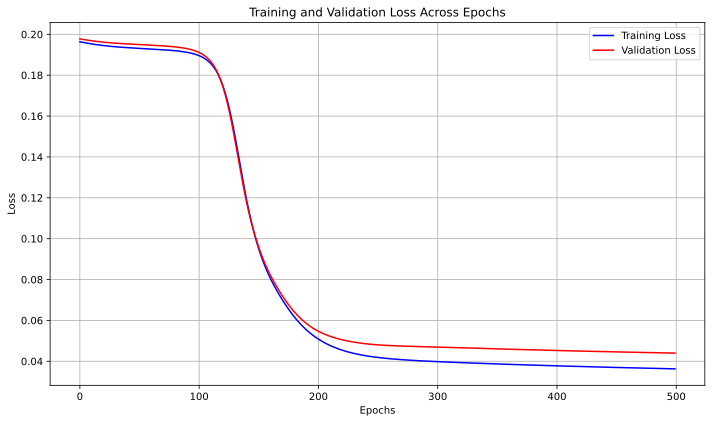

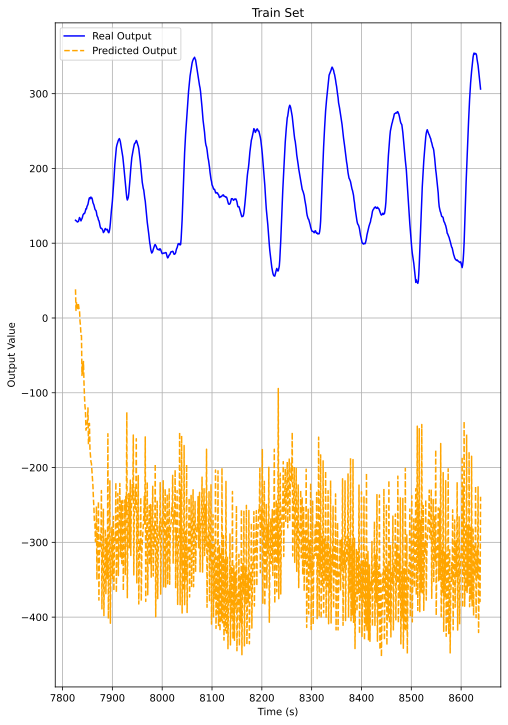

In [15]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

closed_loop_REN_2.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch = u_batch.to("cpu"), y_batch.to("cpu")
    

    closed_loop_REN_2.eval()
    _, y_hat = closed_loop_REN_2(x0, u_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()